In [10]:
from openparticle import ParticleOperator, Fock
from openparticle.utils import get_fock_basis, generate_matrix

import numpy as np
import math
from scipy.linalg import expm
import scipy
from symmer import PauliwordOp
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.backends.backend_pdf
from typing import List

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rc('text', usetex=True)

In [2]:
Ef, Eb, g = 1, 1, 1

In [3]:
def get_bare_hamiltonian(Ef, Eb, g):
    return Ef * ParticleOperator('b0^ b0') + Eb * ParticleOperator('a0^ a0') +\
        g * ParticleOperator('b0^ b0') * (ParticleOperator('a0^') + ParticleOperator('a0')) 

def phase_space_rotation_gate(Ef, t, Lambda):
    # exp(-1j theta a^dagger a)
    a_dagger_a_matrix = generate_matrix(ParticleOperator('a0^ a0'), get_fock_basis(ParticleOperator('a0^ a0'), Lambda))
    return expm(-1j * Ef * t * a_dagger_a_matrix)

def padded_phase_space_rotation_gate(Ef, t, Lambda):
    # exp(-1j theta I.. \otimes a^dagger a)
    a_dagger_a_matrix = generate_matrix(ParticleOperator('a0^ a0'), get_fock_basis(ParticleOperator('a0^ a0'), Lambda))
    padded_a_dagger_a_matrix = np.kron(np.eye(2), a_dagger_a_matrix)
    return expm(-1j * Ef * t * padded_a_dagger_a_matrix)

def fermion_Rz_gate(Eb, t):
    # exp(-1j theta b^dagger b)
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    return expm(-1j * Eb * t / 2 * (I - Z))

def padded_fermion_Rz_gate(Eb, t, Lambda):
    # exp(-1j theta b^dagger b \otimes I...)
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    b_dagger_b = (I - Z) / 2
    b_dagger_b_padded = reduce(np.kron, [b_dagger_b, np.eye(Lambda + 1)])

    return expm(-1j * Eb * t * b_dagger_b_padded)

def naive_interaction_gate(g, t, Lambda):
    a_dagger_plus_a_matrix = generate_matrix(ParticleOperator('a0^') + ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0^') + ParticleOperator('a0'), Lambda))
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    b_dagger_b_matrix = (I - Z)/2

    interaction_term = np.kron(b_dagger_b_matrix, a_dagger_plus_a_matrix)
    return expm(-1j * g * t * interaction_term)

def displacement_operator(alpha, Lambda):
    a = generate_matrix(ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0'), Lambda))
    adagger = generate_matrix(ParticleOperator('a0^'), 
                                             get_fock_basis(ParticleOperator('a0^'), Lambda))

    return expm(
        alpha * adagger - alpha.conjugate() * a
    )

def sdf_displacement_operator(alpha, Lambda):
    #spin-dependent force (SDF)
    a = generate_matrix(ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0'), Lambda))
    adagger = generate_matrix(ParticleOperator('a0^'), 
                                             get_fock_basis(ParticleOperator('a0^'), Lambda))
    X = PauliwordOp.from_dictionary({'X': 1.0}).to_sparse_matrix.toarray()
    return expm(
        np.kron(X, alpha * adagger - alpha.conjugate() * a)
    )

def native_interaction_gate(g, t, Lambda):
    alpha = -1j * g * t / 2
    Had = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
    padded_had = reduce(np.kron, [Had, np.eye(Lambda + 1)])
    padded_identity = np.array([[1, 0], [0, 1]])
    return np.kron(padded_identity, displacement_operator(alpha, Lambda)) @ (padded_had @ sdf_displacement_operator(-1 * alpha, Lambda) @ padded_had)

def first_order_trotterized_unitary(Ef, Eb, g, t, Lambda):
    R_theta_boson_gate = padded_phase_space_rotation_gate(Ef, t, Lambda)
    R_theta_fermion_gate = padded_fermion_Rz_gate(Eb, t, Lambda)
    R_theta_interaction_gate = naive_interaction_gate(g, t, Lambda)

    return R_theta_boson_gate @ R_theta_fermion_gate @ R_theta_interaction_gate

def second_order_trotterized_unitary(Ef, Eb, g, t, Lambda):
    R_theta_boson_gate = padded_phase_space_rotation_gate(Ef, t/2, Lambda )
    R_theta_fermion_gate = padded_fermion_Rz_gate(Eb, t/2, Lambda)
    R_theta_interaction_gate = naive_interaction_gate(g, t, Lambda)

    return R_theta_boson_gate @ R_theta_fermion_gate @ R_theta_interaction_gate @ R_theta_fermion_gate @ R_theta_boson_gate

def exact_unitary(Ef, Eb, g, t, Lambda):
    ham_op = Ef * ParticleOperator('b0^ b0') +\
             Eb * ParticleOperator('a0^ a0') +\
             g * ParticleOperator('b0^ b0') * (ParticleOperator('a0^') + ParticleOperator('a0'))
    ham_op_matrix = generate_matrix(
        ham_op, get_fock_basis(ham_op, Lambda), Lambda
    )
    return expm(-1j * t * ham_op_matrix)

def first_order_trotter_evolve_statevector(t, Ef, Eb, g, Lambda, statevector):
    return first_order_trotterized_unitary(Ef, Eb, g, t, Lambda) @ statevector

def second_order_trotter_evolve_statevector(t, Ef, Eb, g, Lambda, statevector):
    return second_order_trotterized_unitary(Ef, Eb, g, t, Lambda) @ statevector

def exact_evolve_statevector(t, Ef, Eb, g, Lambda, statevector):
    return exact_unitary(Ef, Eb, g, t, Lambda) @ statevector

In [4]:
def compute_expectation_value(
        statevector,
        cutoff,
        operator: str,
        trotterization: str,
        t: float, 
        g: float = 1.0,
        Ef: float = 1.0,
        Eb: float = 1.0
):
    
    if operator == 'number_op_fermion':
        number_operator_ferm = ParticleOperator('b0^ b0')
        number_operator_ferm_matrix = generate_matrix(number_operator_ferm, get_fock_basis(number_operator_ferm, cutoff))
        padded_matrix_operator = reduce(np.kron, [number_operator_ferm_matrix, np.eye(cutoff + 1)])
    elif operator == 'number_op_boson':
        number_operator_bose = ParticleOperator('a0^ a0')
        number_operator_bose_matrix = generate_matrix(number_operator_bose, get_fock_basis(number_operator_bose, cutoff))
        padded_matrix_operator = reduce(np.kron, [np.eye(2), number_operator_bose_matrix])
    elif operator == 'position_op':
        a_dagger_a = ParticleOperator('a0^') + ParticleOperator('a0')
        a_dagger_a_matrix = generate_matrix(a_dagger_a, get_fock_basis(a_dagger_a, cutoff))
        padded_matrix_operator = reduce(np.kron, [np.eye(2), a_dagger_a_matrix])

    
    if trotterization == 'exact':
        evolved_statevector = exact_evolve_statevector(t, Ef, Eb, g, cutoff, statevector)
    elif trotterization == 'first_order':
        evolved_statevector = first_order_trotter_evolve_statevector(t, Ef, Eb, g, cutoff, statevector)
    elif trotterization == 'second_order':
        evolved_statevector = second_order_trotter_evolve_statevector(t, Ef, Eb, g, cutoff, statevector)

    return evolved_statevector.T.conjugate() @ padded_matrix_operator @ evolved_statevector
     

In [5]:
def get_boson_state(n_bosons, cutoff):
    boson_state = np.zeros(cutoff + 1).reshape(-1, 1)
    boson_state[n_bosons] = 1
    return boson_state

def get_fermion_state(n_fermions):
    if n_fermions == 0:
        return np.array([[1, 0]]).reshape(-1, 1)
    elif n_fermions == 1:
        return np.array([[0, 1]]).reshape(-1, 1)

In [6]:
def compute_expectation_values_t(
        fermion_state: str,
        boson_state: str,
        cutoff: int,
        trotterization: str,
        operator: str,
        t_values: List,
        g: float = 1.0,
        Ef: float = 1.0,
        Eb: float = 1.0
):
    """
    Args:

    - fermion_state (str): 'single_fermion' or 'plus_state'
    - boson_state (str): 'zero_boson' or 'coherent_boson'
    - trotterization (str): 'exact' or 'first_order' or 'second_order'
    - expectation_value_type (str): 'number_op_boson' or 'number_op_fermion' or 'position_op'

    """

    expectation_values = []

    if fermion_state == 'single_fermion':
        fermion = get_fermion_state(1)
    elif fermion_state == 'plus_fermion':
        fermion = get_fermion_state(0) + get_fermion_state(1)
        fermion = 1/np.linalg.norm(fermion) * fermion
        

    if boson_state == 'zero_boson':
        boson = get_boson_state(0, cutoff)
    elif boson_state == 'coherent_boson':
        boson = displacement_operator(alpha = -1j * g / 2, Lambda = cutoff) @ get_boson_state(0, cutoff)

    statevector = np.kron(fermion, boson)

    
    for t in t_values:
        exp_val = compute_expectation_value(
                statevector, cutoff, operator, trotterization, t,
                g = g, Ef = Ef, Eb = Eb
            )
        expectation_values.append(exp_val[0].real)

    return np.array(expectation_values)


In [7]:
def get_plot_y_label(operator_expectation):
    if operator_expectation == 'number_op_fermion':
        return r'$\langle b^\dagger b \rangle$'
    elif operator_expectation == 'number_op_boson':
        return r'$\langle a^\dagger a \rangle$'
    elif operator_expectation == 'position_op':
        return r'$\langle a^\dagger + a \rangle$'
    
def get_plot_title(fermion_state, boson_state):
    title_str = r'$|\psi(0)\rangle = $'
    if fermion_state == 'single_fermion':
        if boson_state == 'zero_boson':
            title_str += r'$|1_f 0_b\rangle$'
        elif boson_state == 'coherent_boson':
            title_str += r'$|1_f \alpha_b\rangle$'
    elif fermion_state == 'plus_fermion':
        if boson_state == 'zero_boson':
            title_str += r'$|+_f 0_b\rangle$'
        elif boson_state == 'coherent_boson':
            title_str += r'$|+_f \alpha_b\rangle$'
    return title_str

In [8]:
fermion_state = 'single_fermion'
boson_state = 'zero_boson'
Lambda = 3
trotterization_approximation = 'exact'
operator_expectation = 'number_op_boson'
t_arr = np.arange(0, 100, 0.1)

exp_vals = compute_expectation_values_t(
    fermion_state, boson_state, Lambda, trotterization_approximation, operator_expectation, t_arr
)


In [9]:
plt.figure(figsize=(6, 3), dpi=150)

if trotterization_approximation == 'exact':
    linestyle = 'solid'
elif trotterization_approximation == 'first_order':
    linestyle = 'dashed'
elif trotterization_approximation == 'second_order':
    linestyle = 'dotted'

cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=1, vmax=Lambda_max)

plt.plot(t_arr, exp_vals, linestyle = linestyle, color = cmap(norm(Lambda)))
plt.ylabel(
    get_plot_y_label(operator_expectation)
)
plt.title(get_plot_title(fermion_state, boson_state))
plt.xlabel(r'$t$')


NameError: name 'Lambda_max' is not defined

<Figure size 900x450 with 0 Axes>

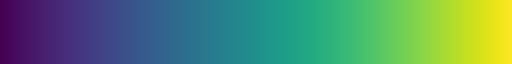

In [ ]:
cmap

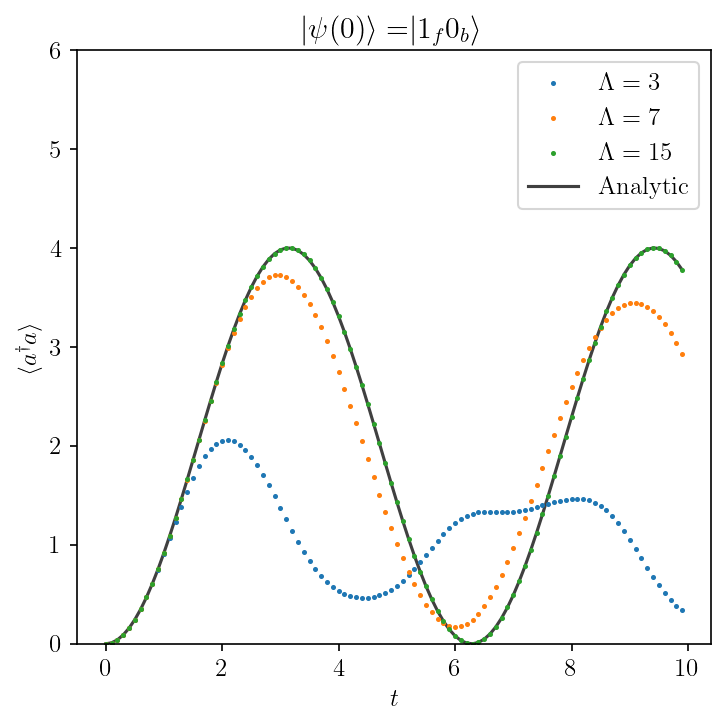

In [ ]:
t_arr = np.arange(0, 10, 0.1)
Lambda_max = 2**4

fermion_state = 'single_fermion'
boson_state = 'zero_boson'
trotterization_approximation = 'exact'
operator_expectation = 'number_op_boson'


exp_vals_lambda3 = compute_expectation_values_t(
    fermion_state, boson_state, 3, trotterization_approximation, operator_expectation, t_arr
)
exp_vals_lambda7 = compute_expectation_values_t(
    fermion_state, boson_state, 7, trotterization_approximation, operator_expectation, t_arr
)
exp_vals_lambda15 = compute_expectation_values_t(
    fermion_state, boson_state, 15, trotterization_approximation, operator_expectation, t_arr
)


cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=1, vmax=Lambda_max)

plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(t_arr, exp_vals_lambda3, marker = 'o', s = 2, label = r'$\Lambda = 3$')
plt.scatter(t_arr, exp_vals_lambda7, marker = 'o', s = 2, label = r'$\Lambda = 7$')
plt.scatter(t_arr, exp_vals_lambda15, marker = 'o', s = 2, label = r'$\Lambda = 15$')
plt.plot(t_arr, -2*np.cos(t_arr) + 2, color = 'k', alpha = 0.75, label = 'Analytic', zorder = -1)
plt.ylabel(
    get_plot_y_label(operator_expectation)
)
plt.ylim(0, 6)
plt.title(get_plot_title(fermion_state, boson_state))
plt.xlabel(r'$t$')
plt.legend()
plt.tight_layout()
plt.savefig('./static_yukawa_plots/exact.pdf')
plt.show()

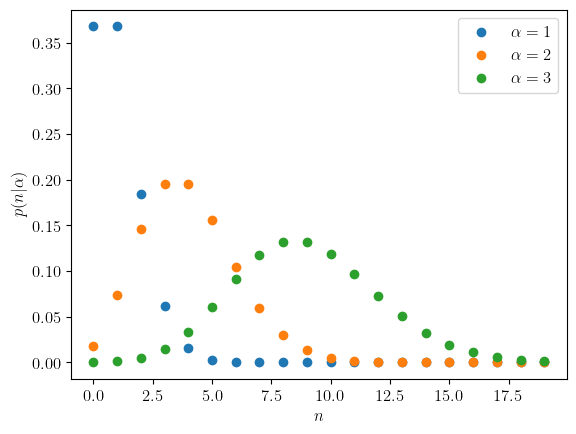

In [54]:
def p(n, alpha):
    return (np.exp(-np.abs(alpha)**2 / 2) * (alpha ** n) / np.sqrt(scipy.special.factorial(n)))**2

Lambda = 20

n = np.arange(0, Lambda, 1)

plt.scatter(n, p(n, 1), label = r'$\alpha = 1$')
plt.scatter(n, p(n, 2), label = r'$\alpha = 2$')
plt.scatter(n, p(n, 3), label = r'$\alpha = 3$')
plt.ylabel(r'$p(n|\alpha)$')
plt.xlabel(r'$n$')
plt.legend()

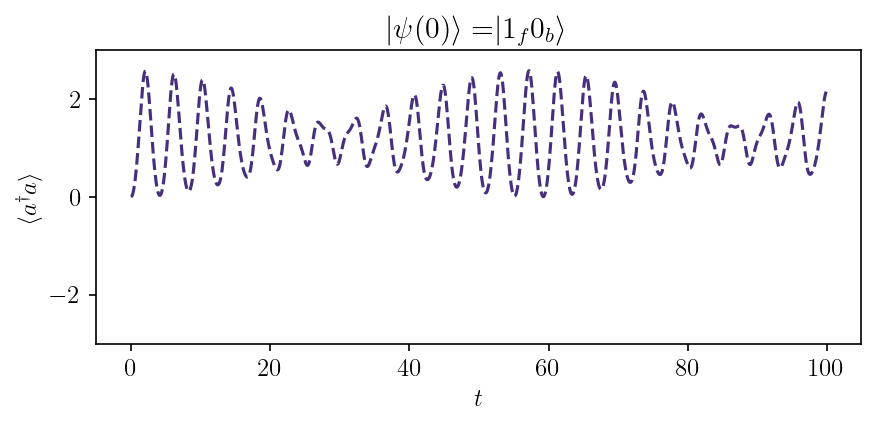

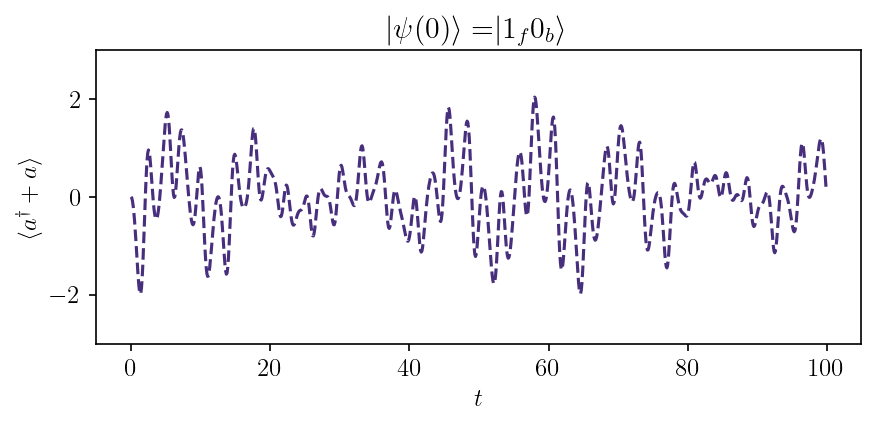

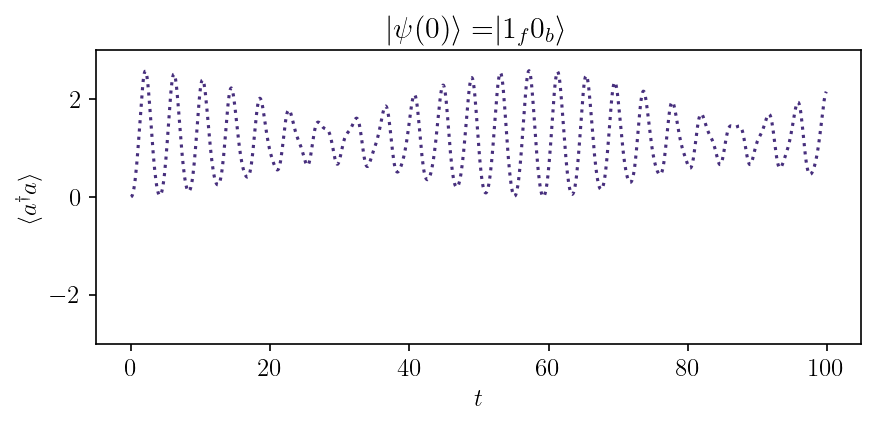

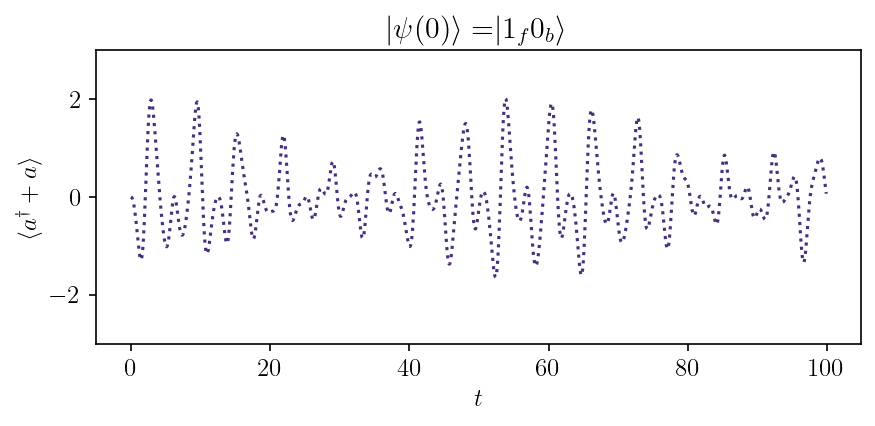

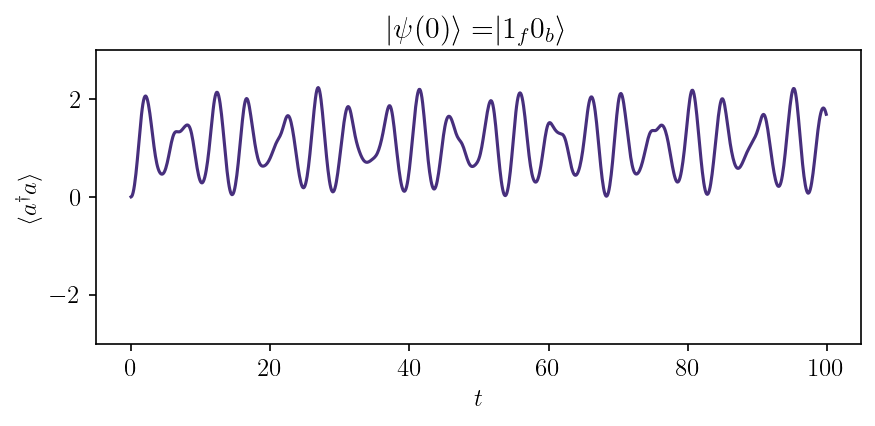

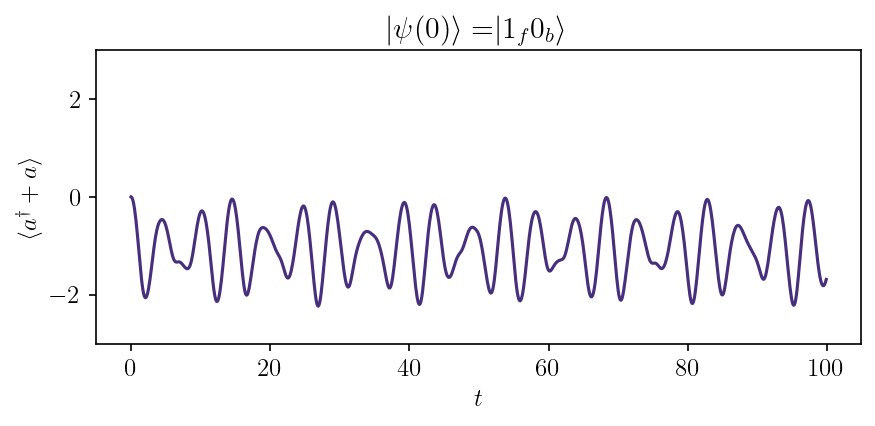

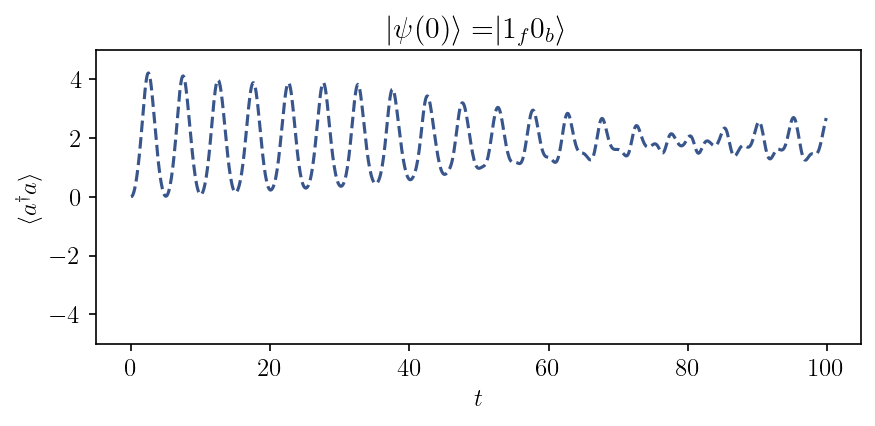

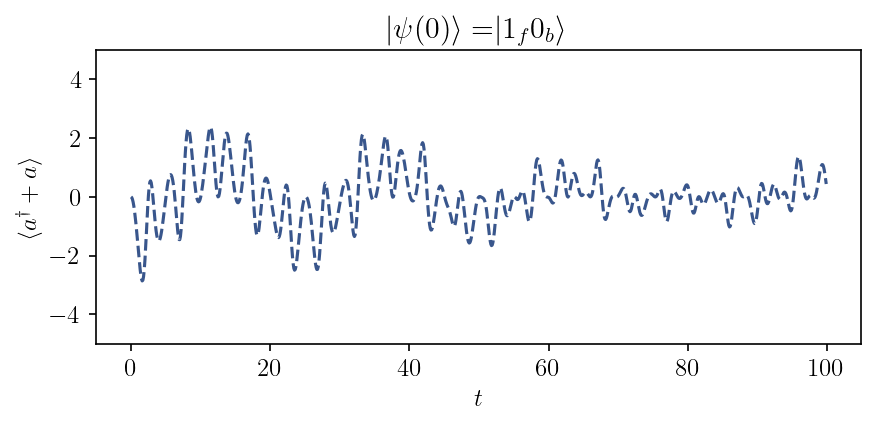

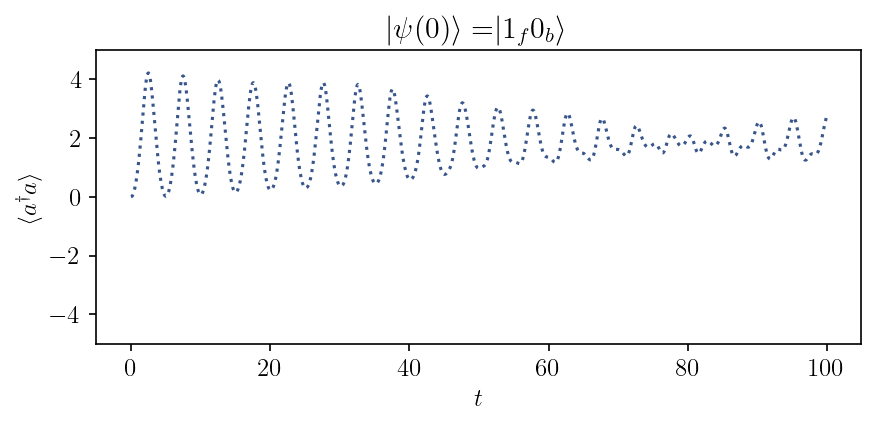

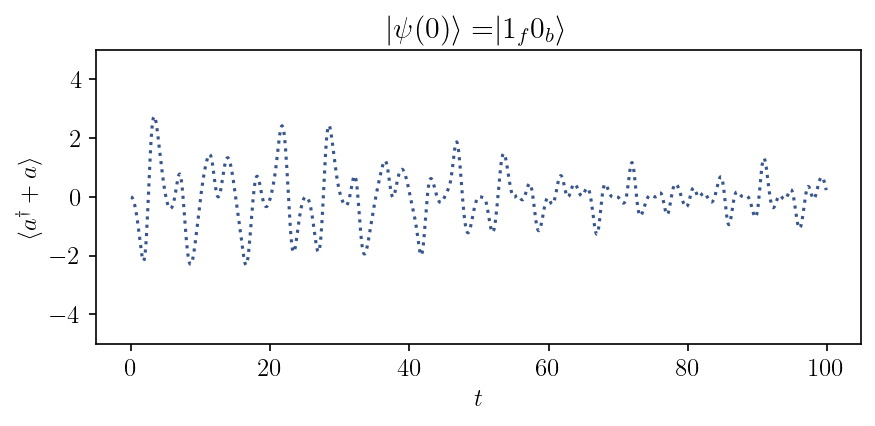

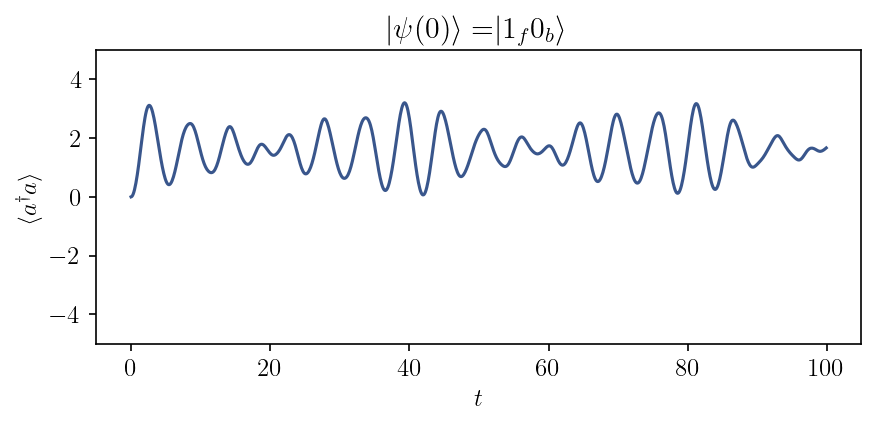

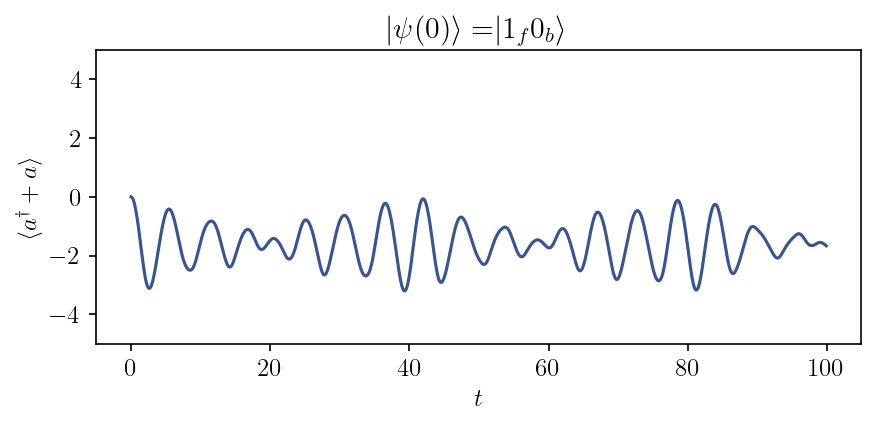

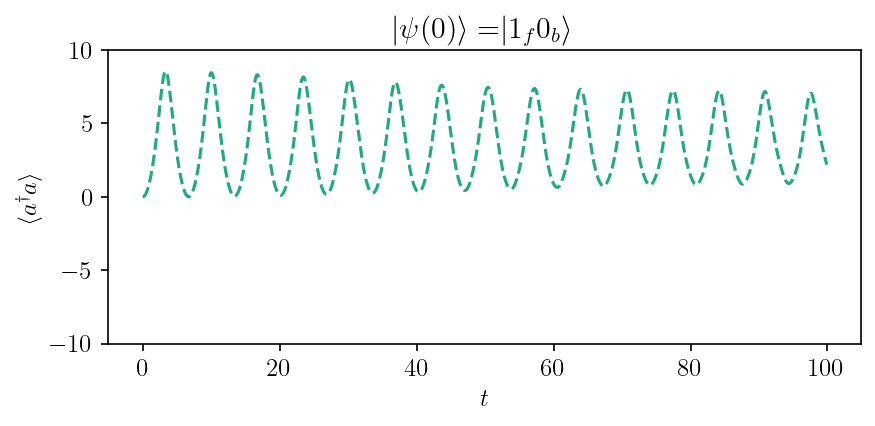

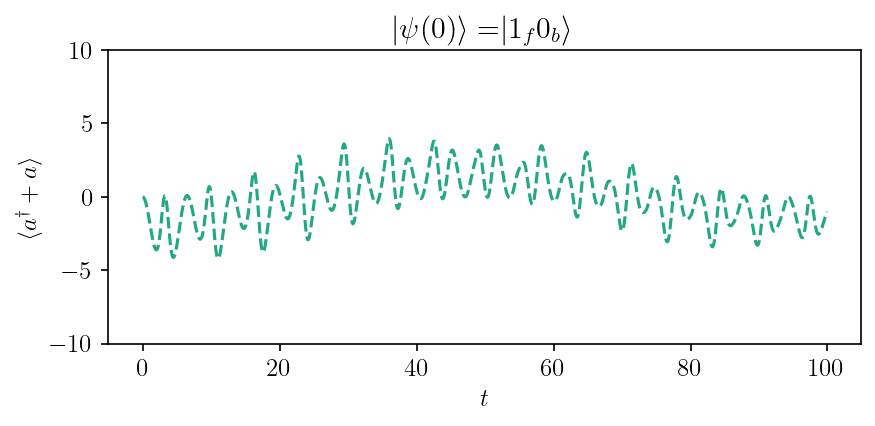

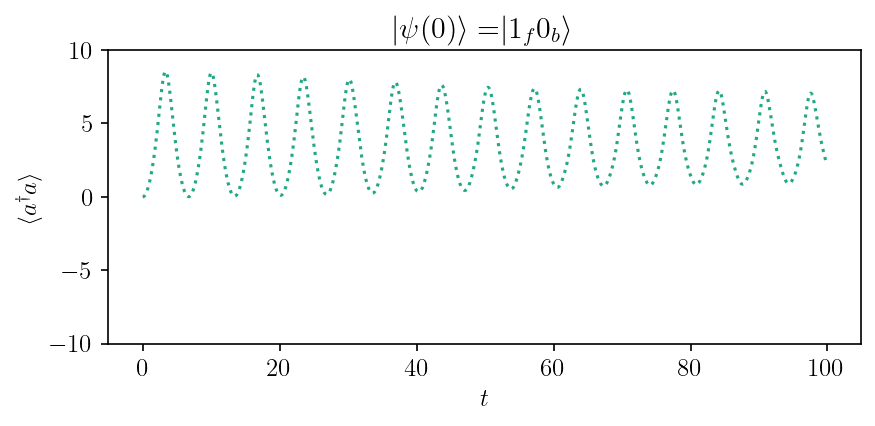

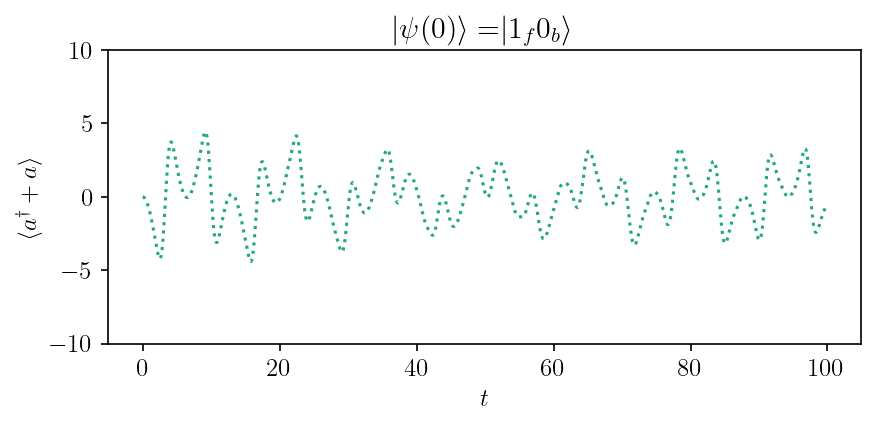

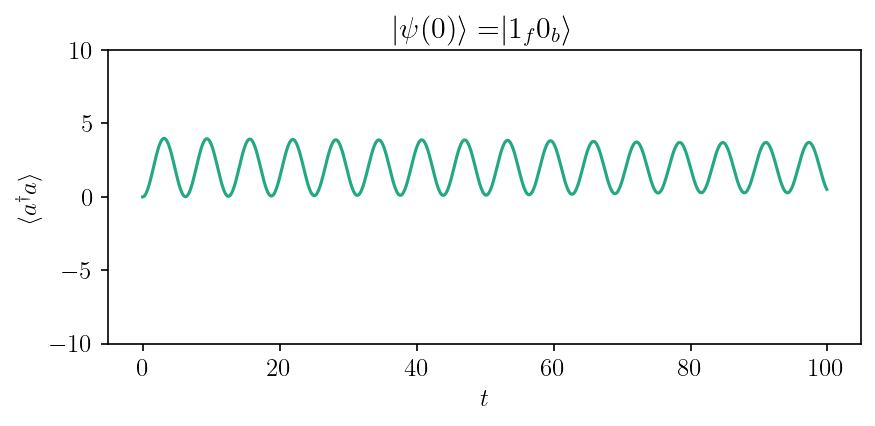

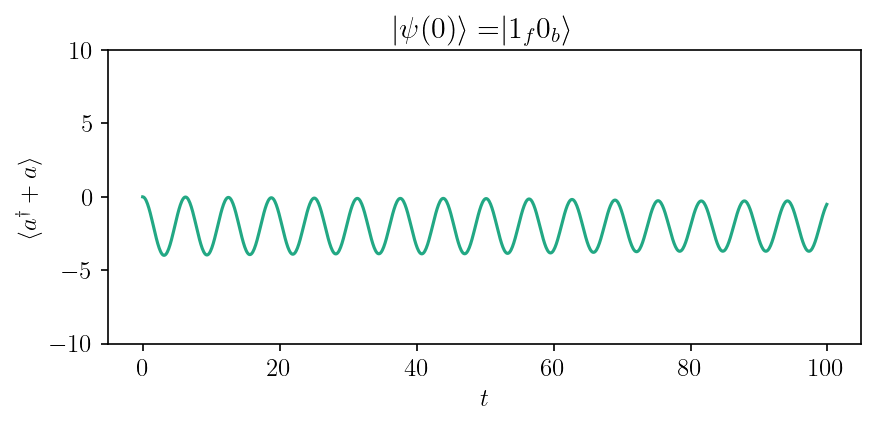

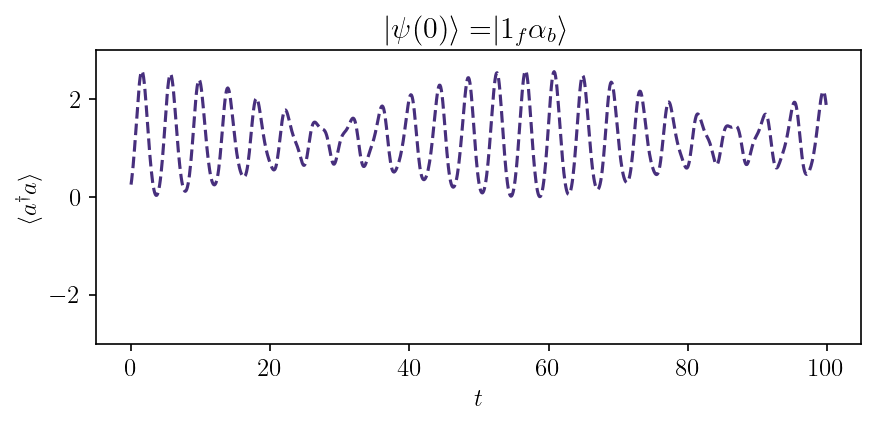

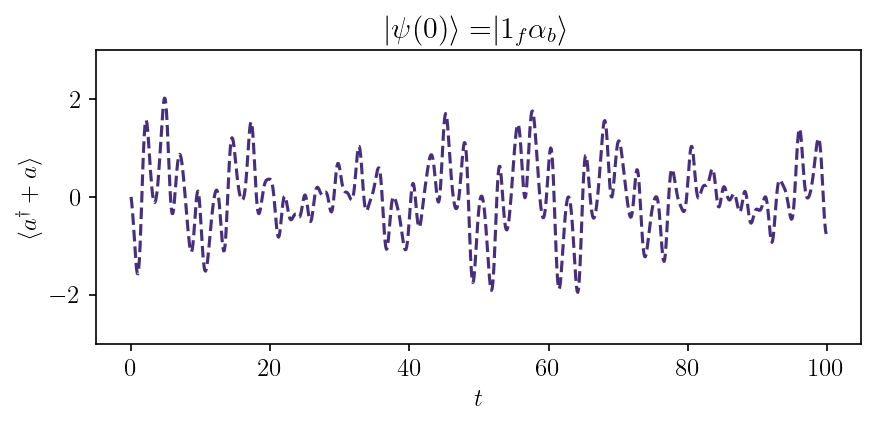

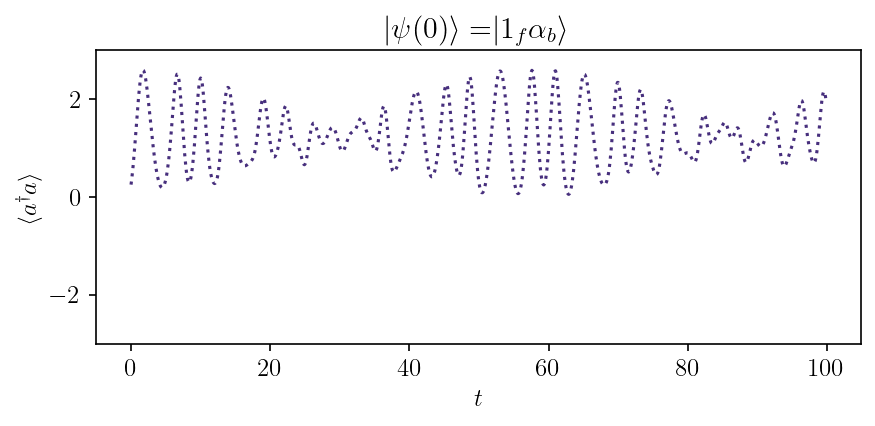

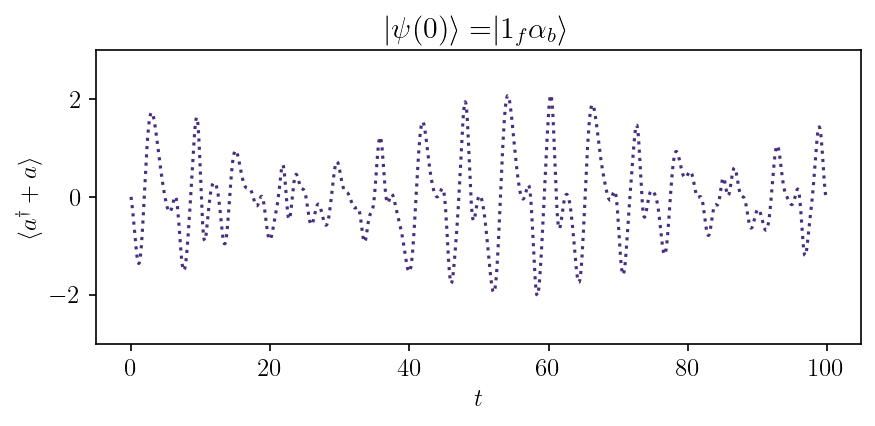

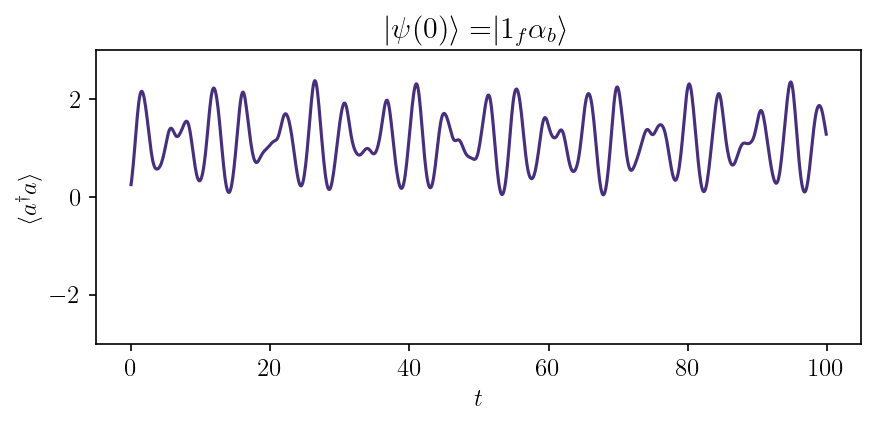

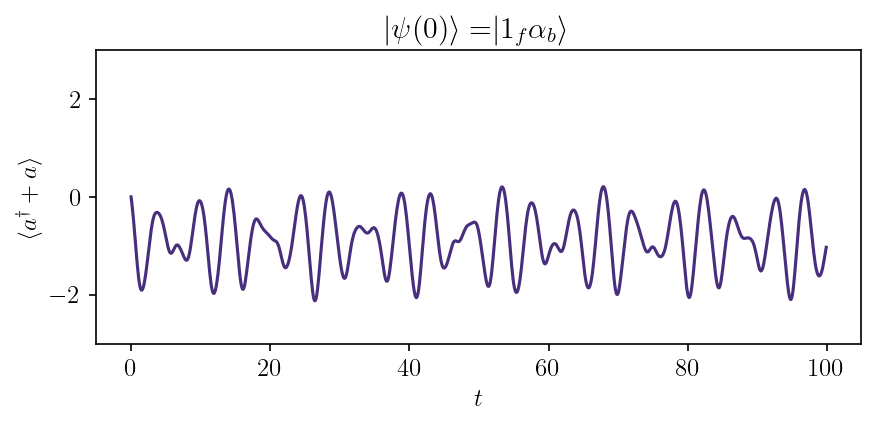

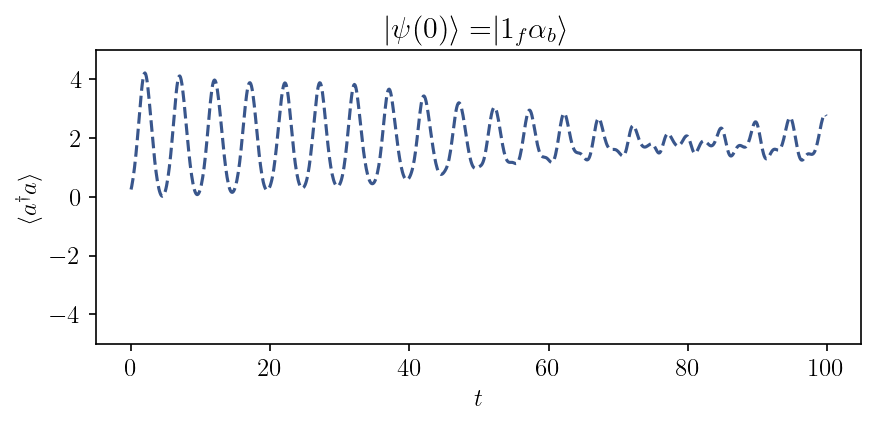

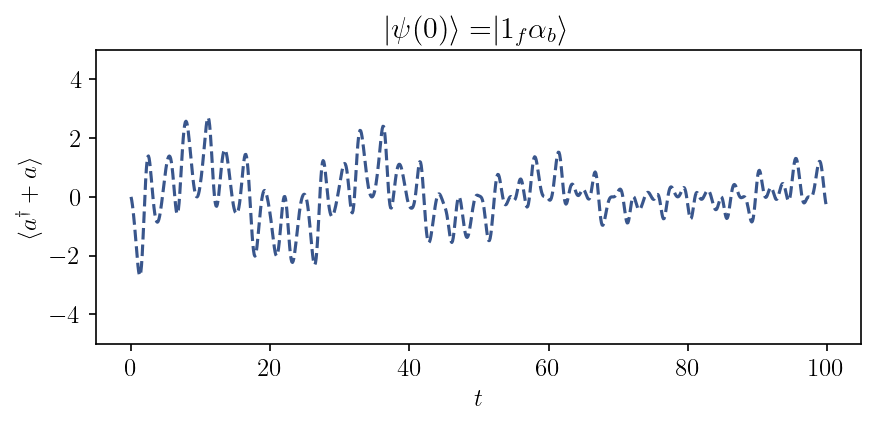

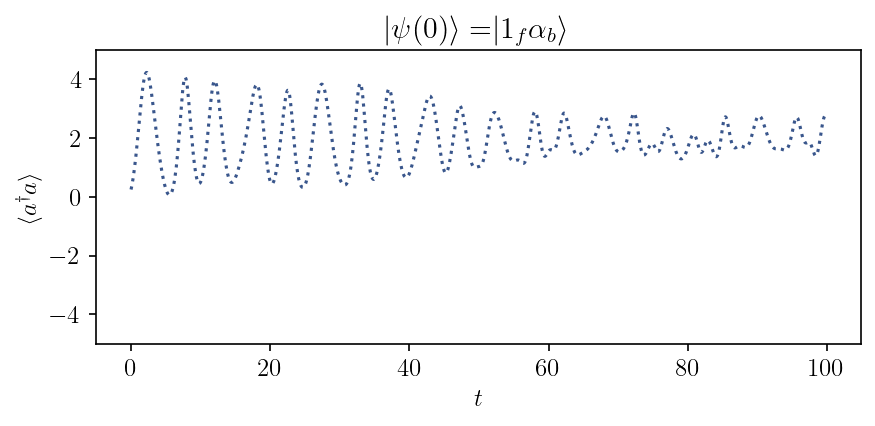

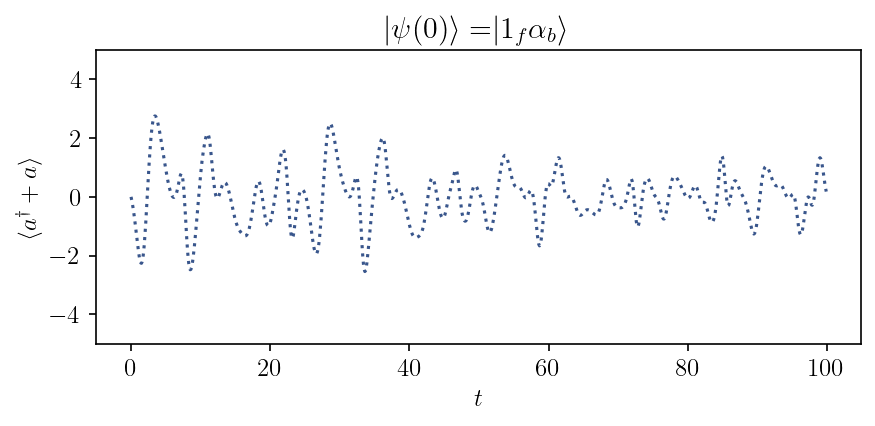

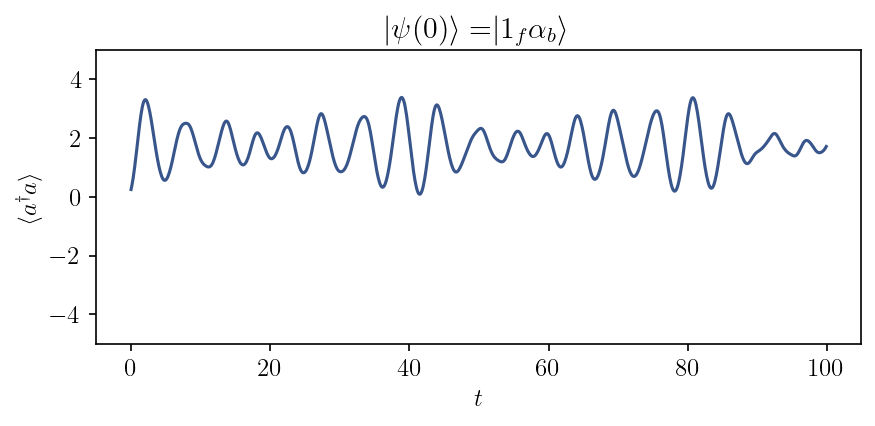

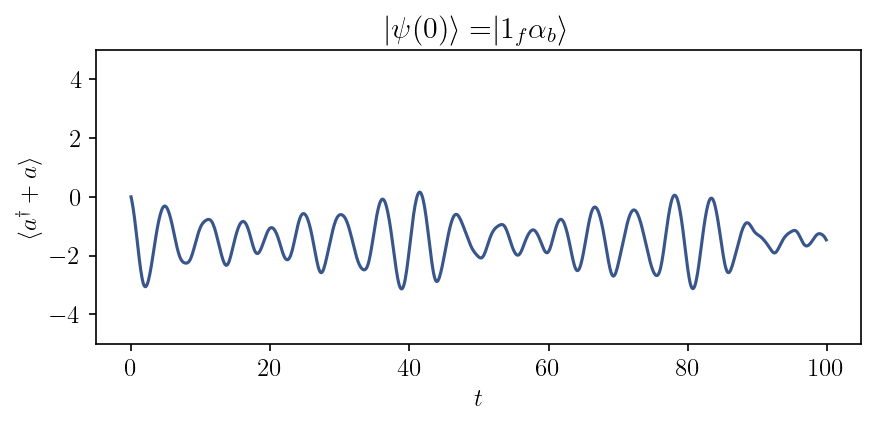

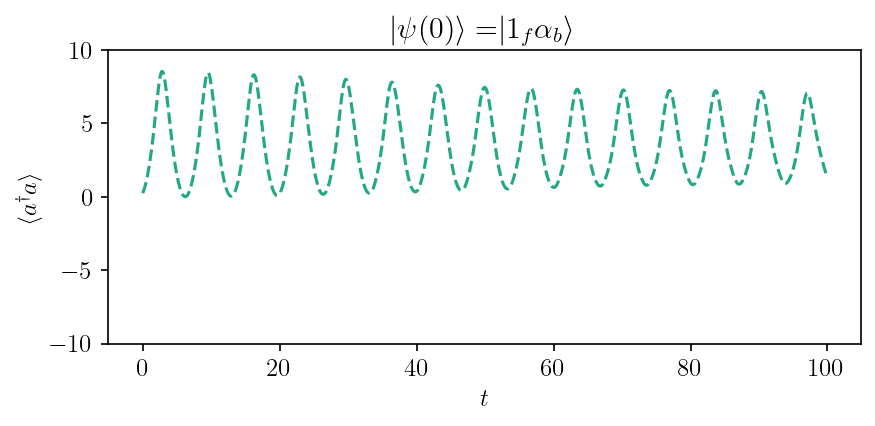

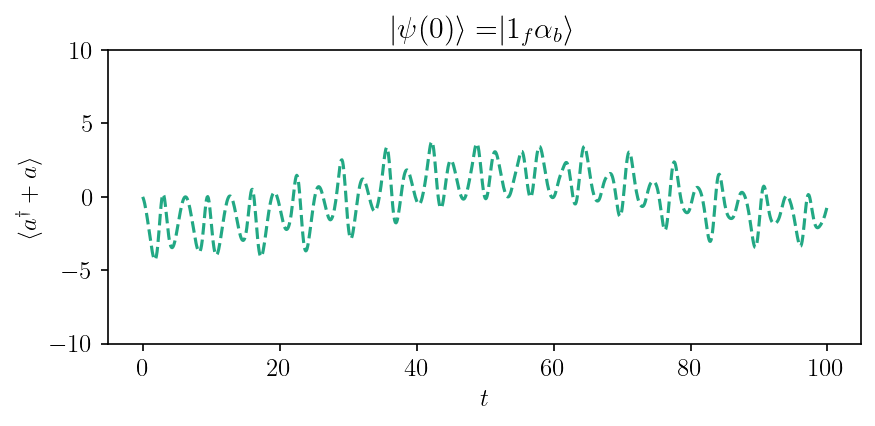

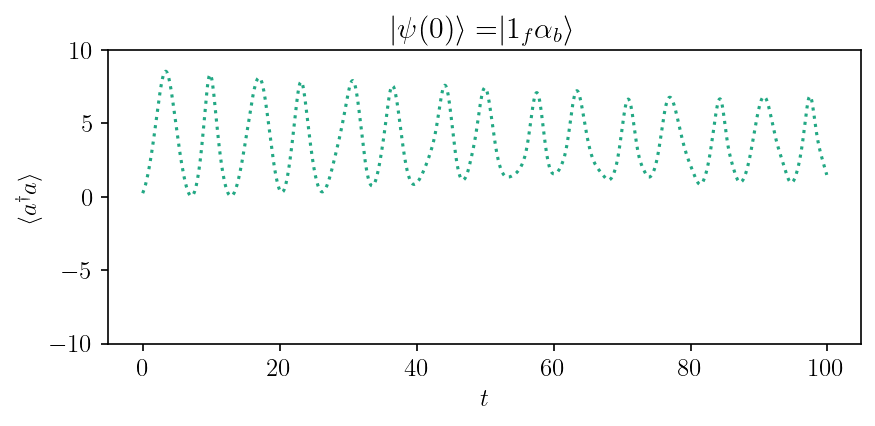

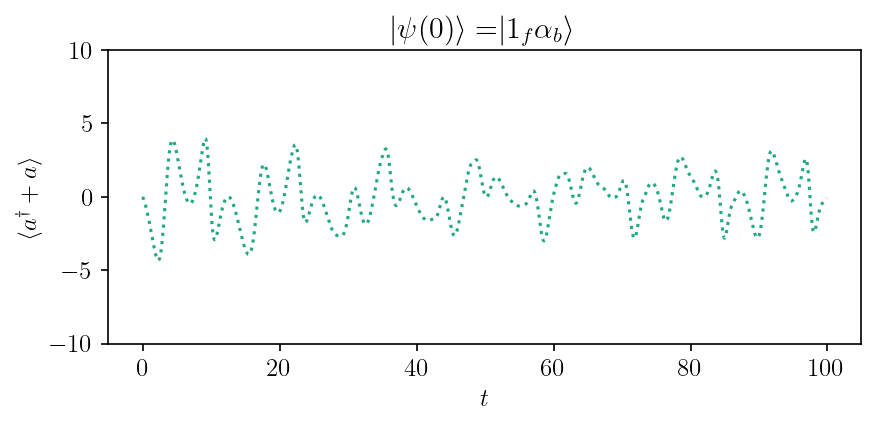

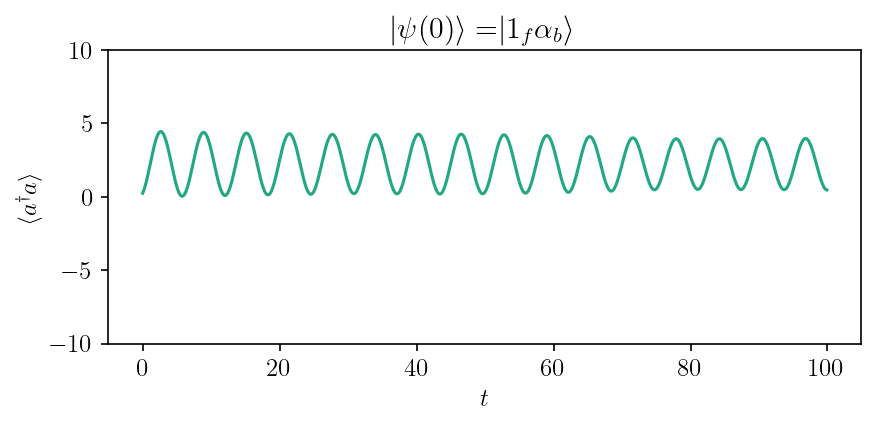

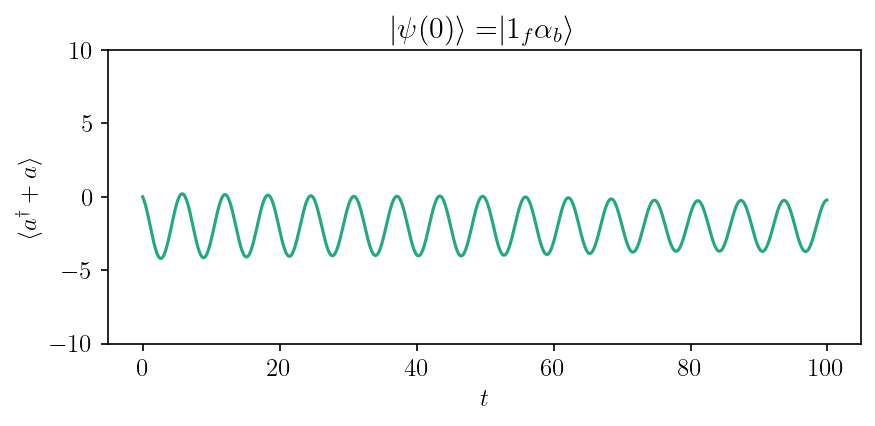

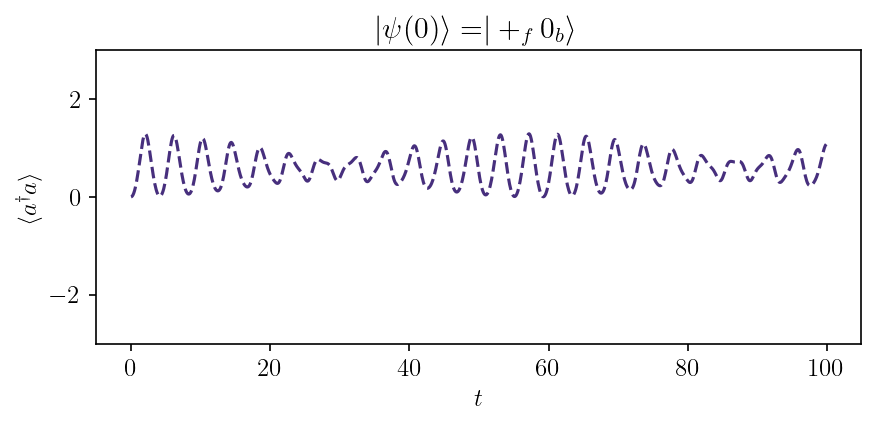

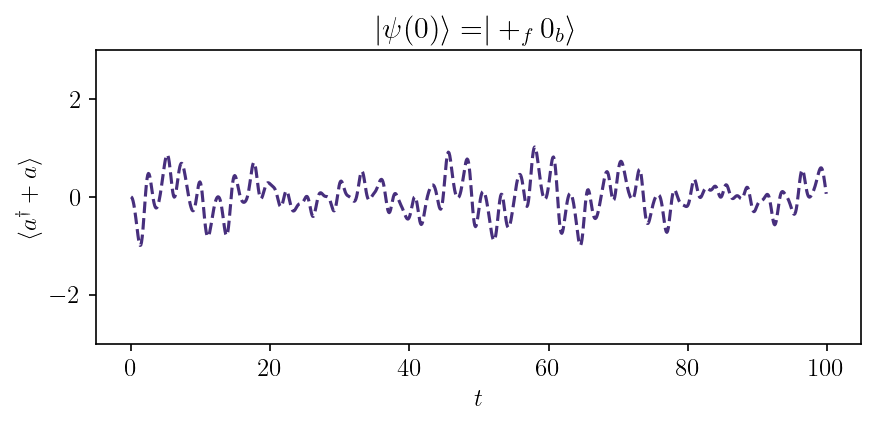

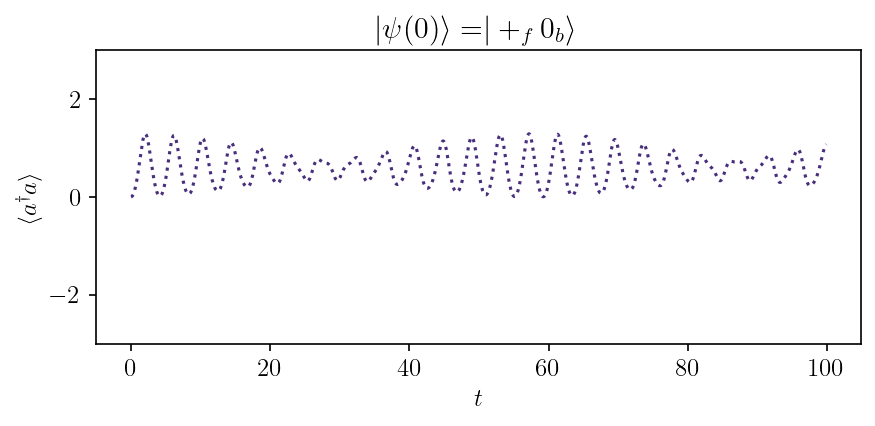

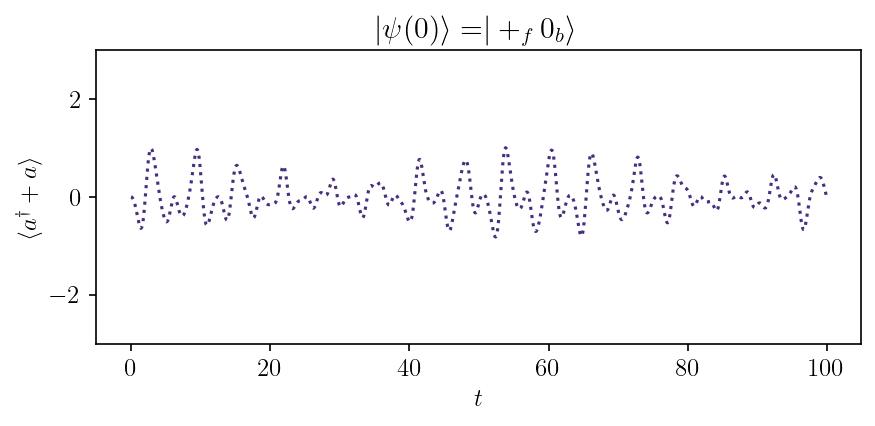

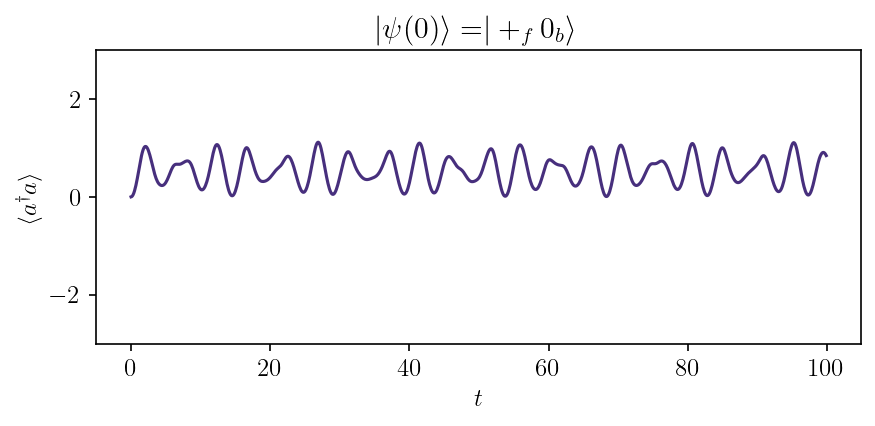

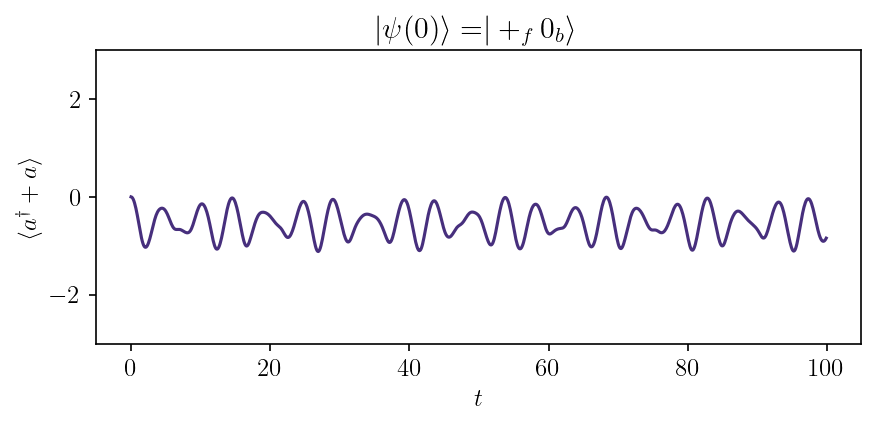

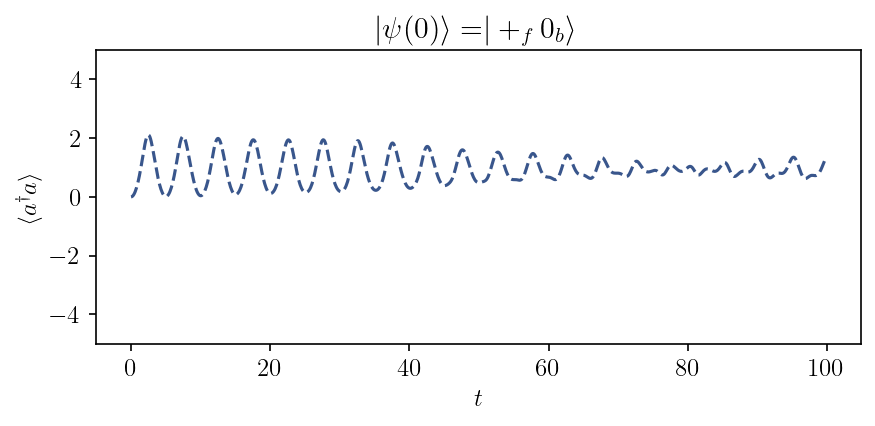

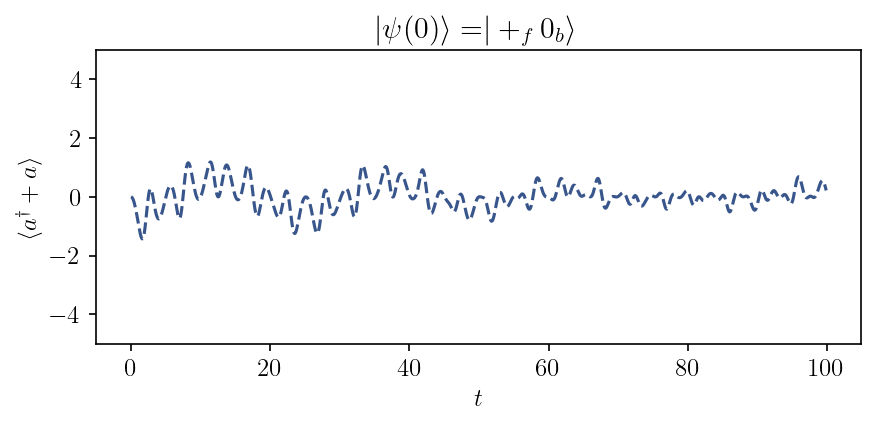

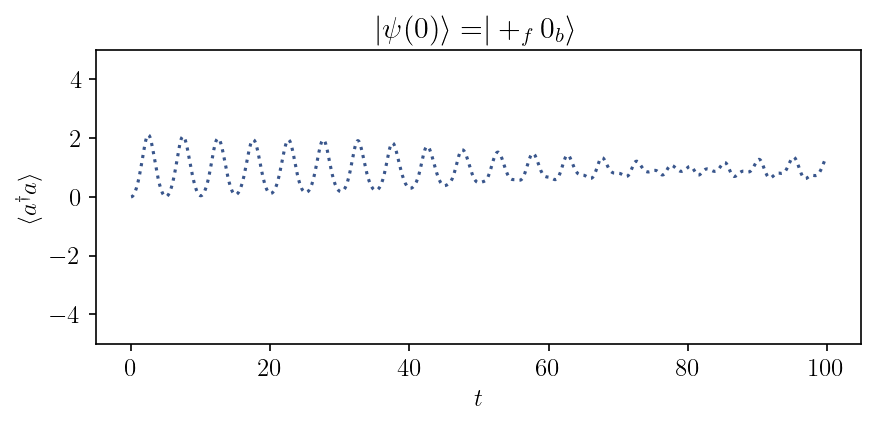

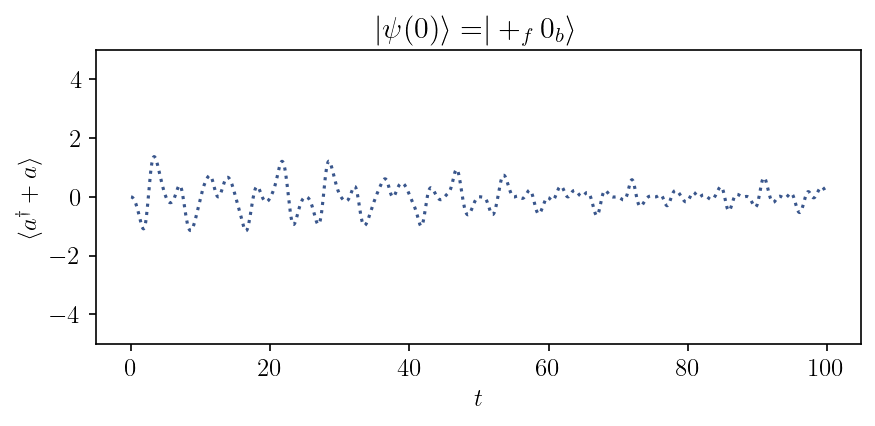

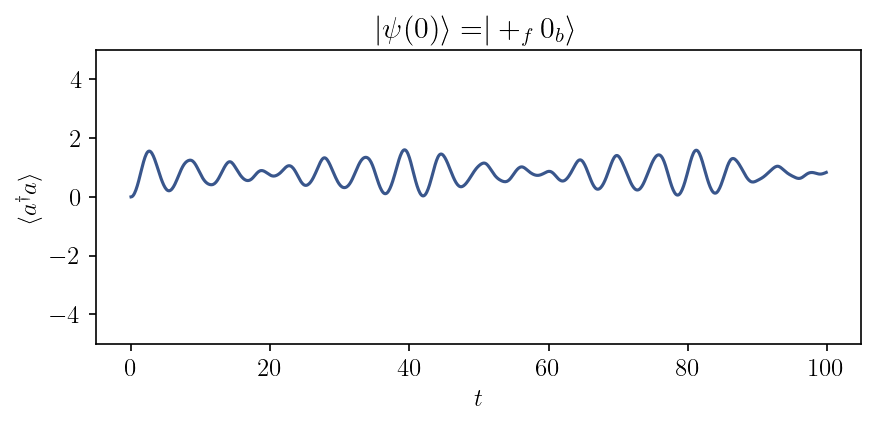

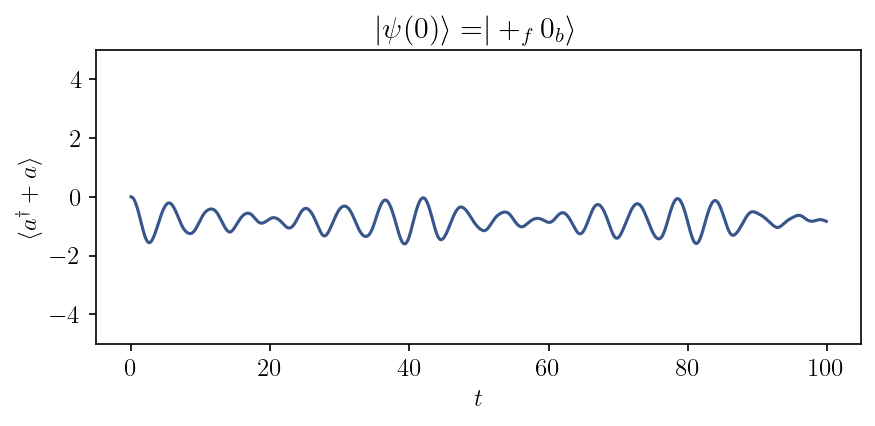

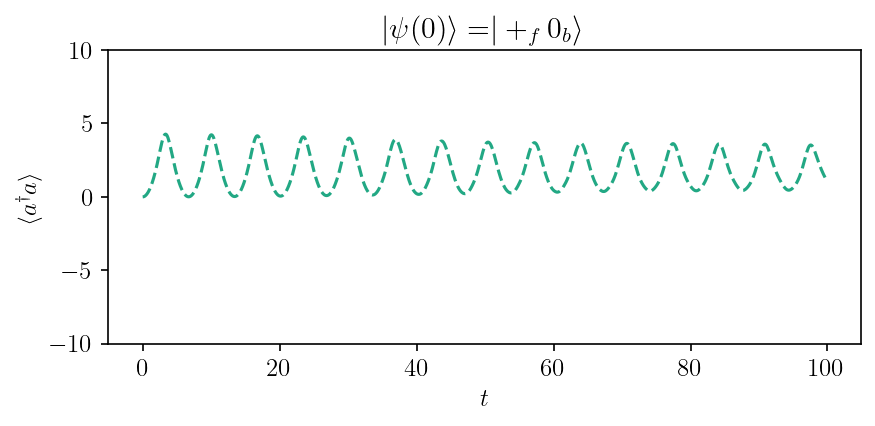

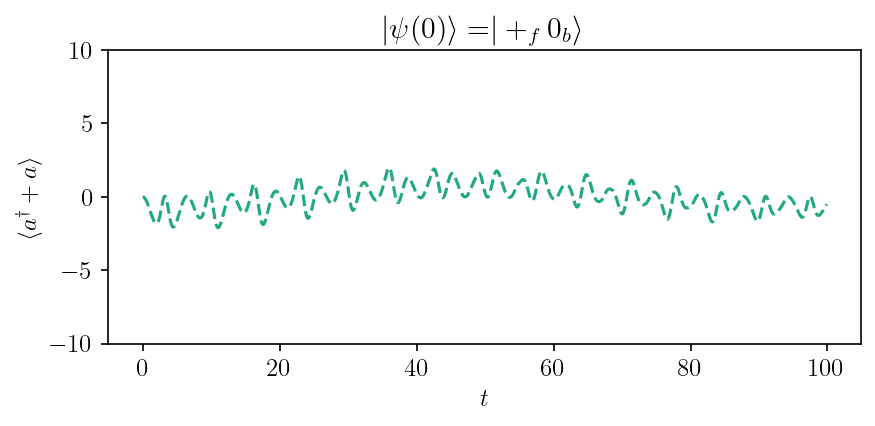

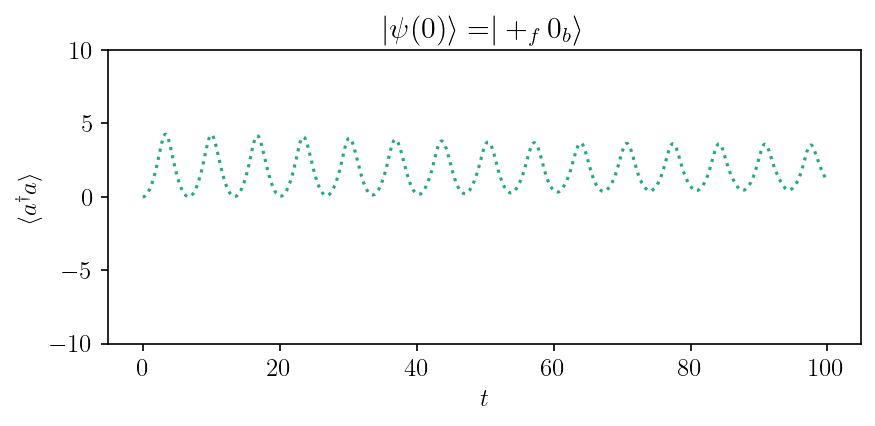

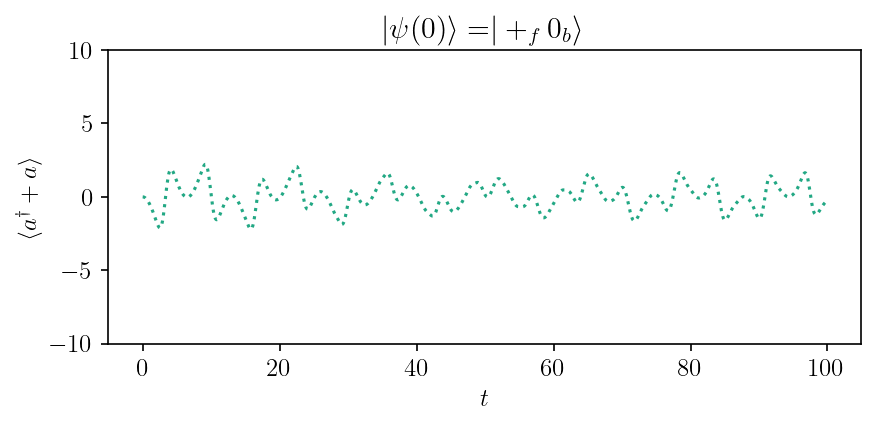

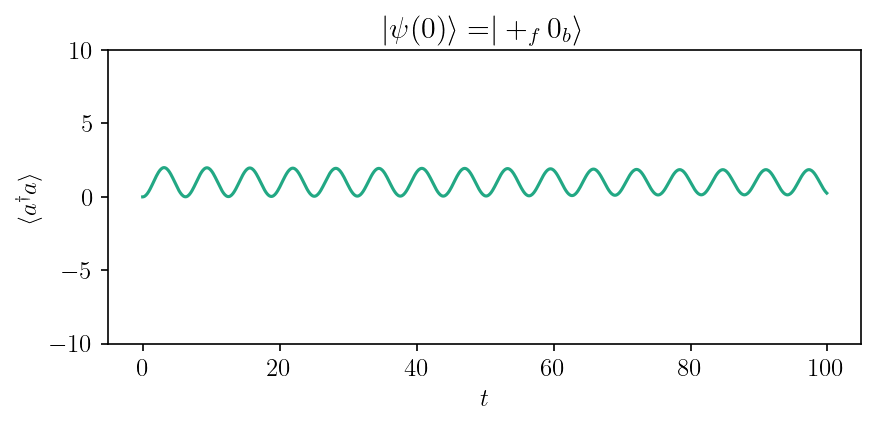

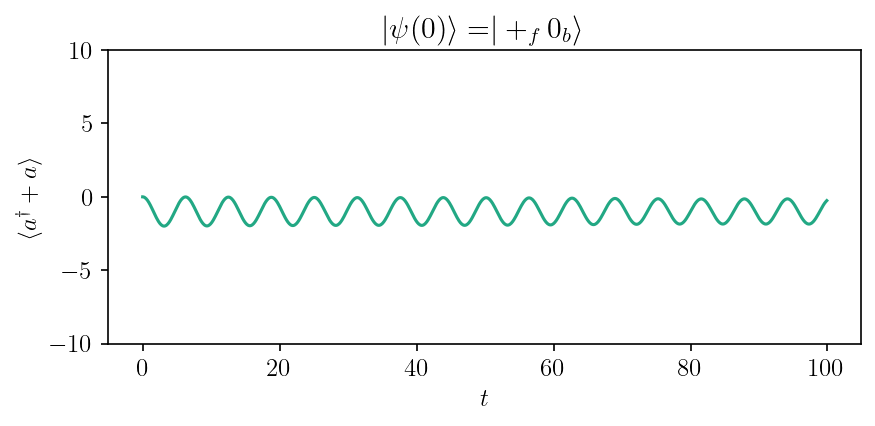

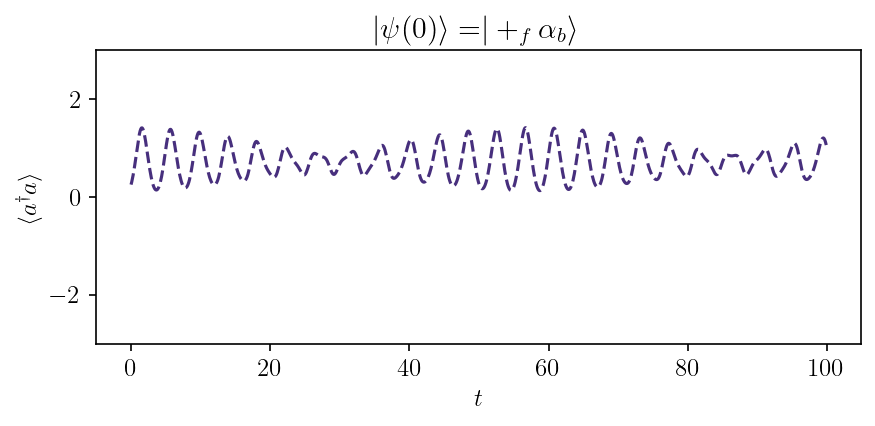

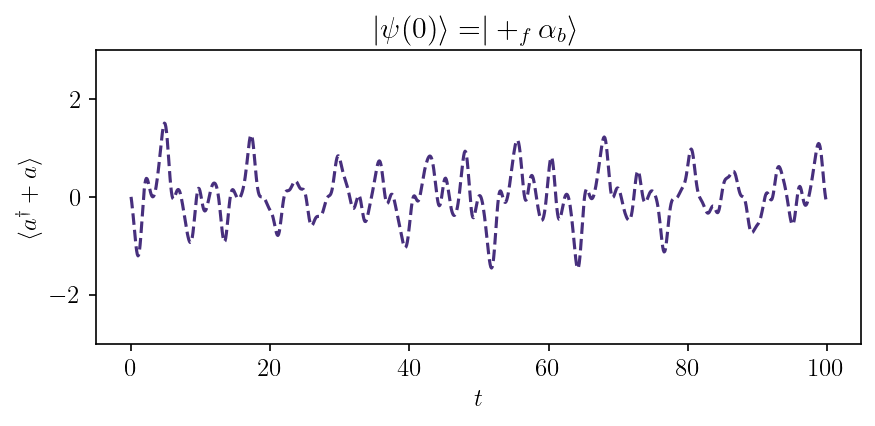

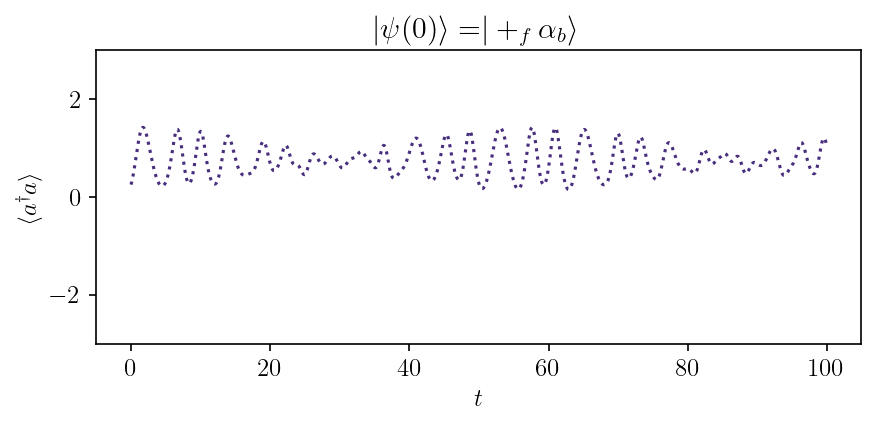

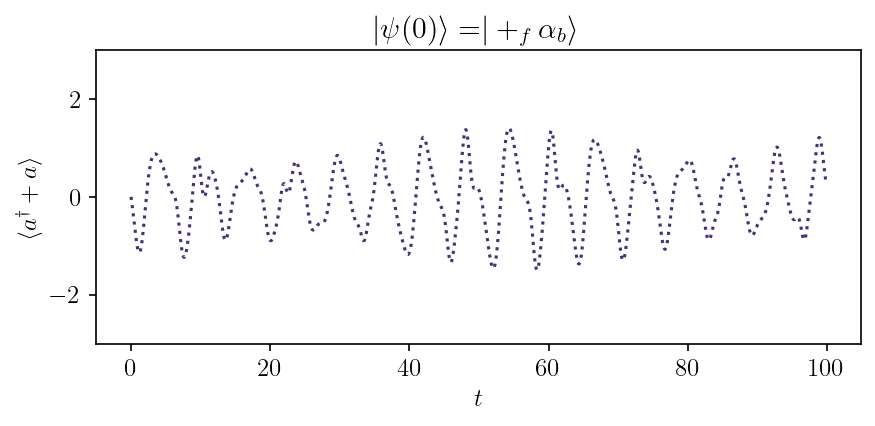

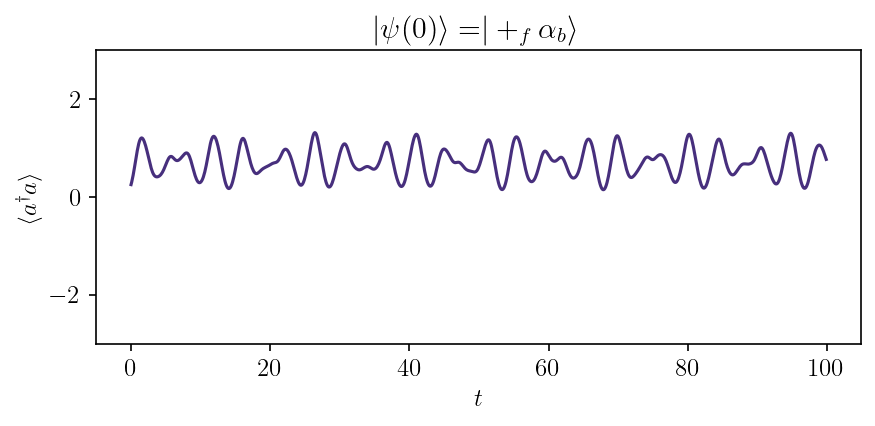

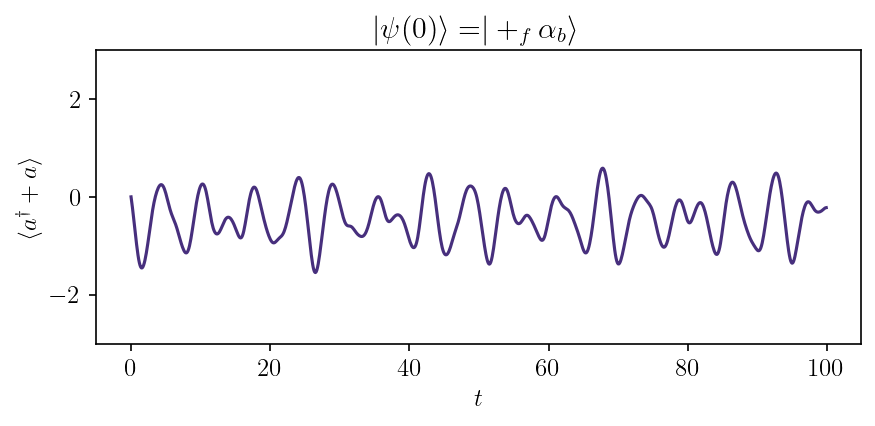

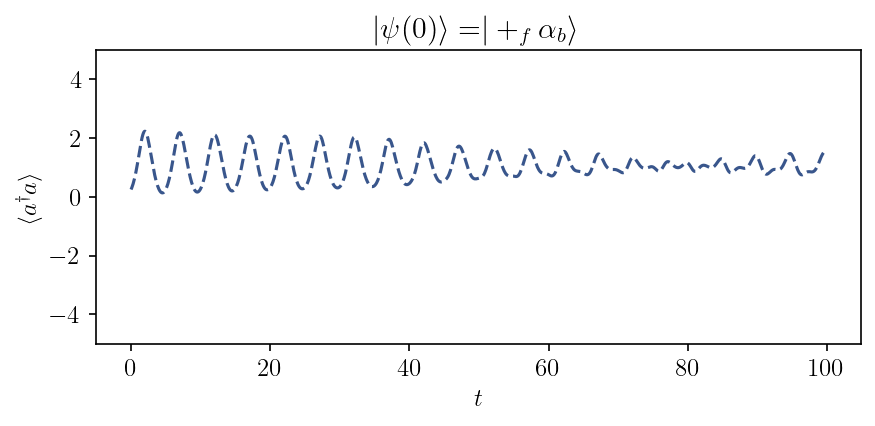

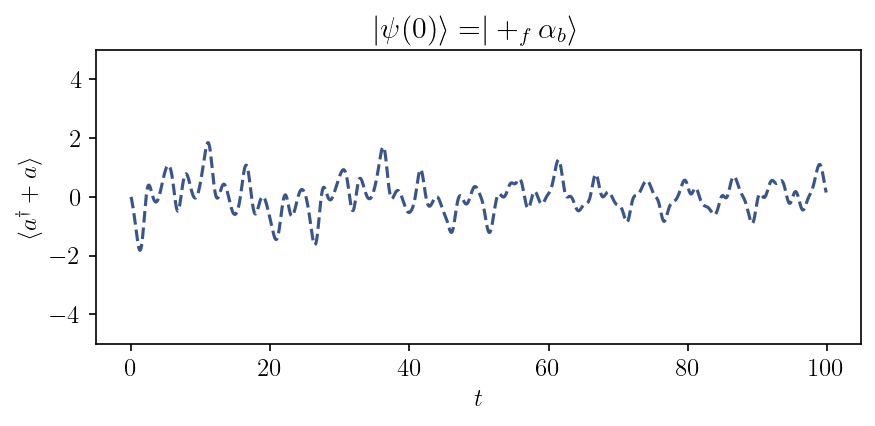

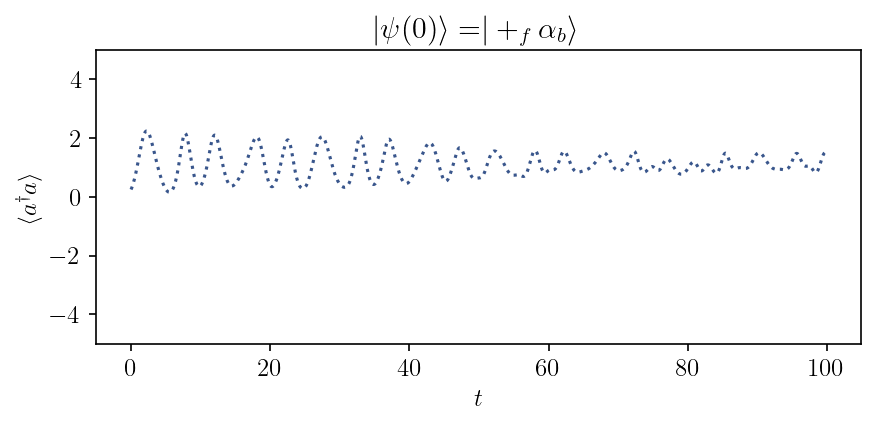

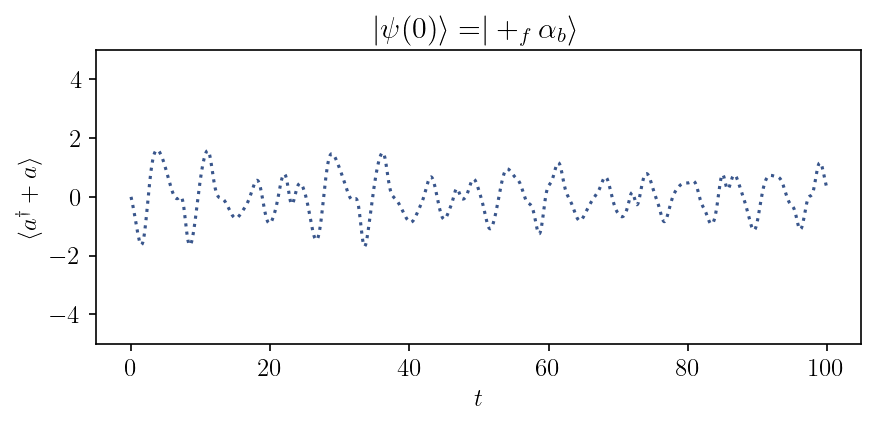

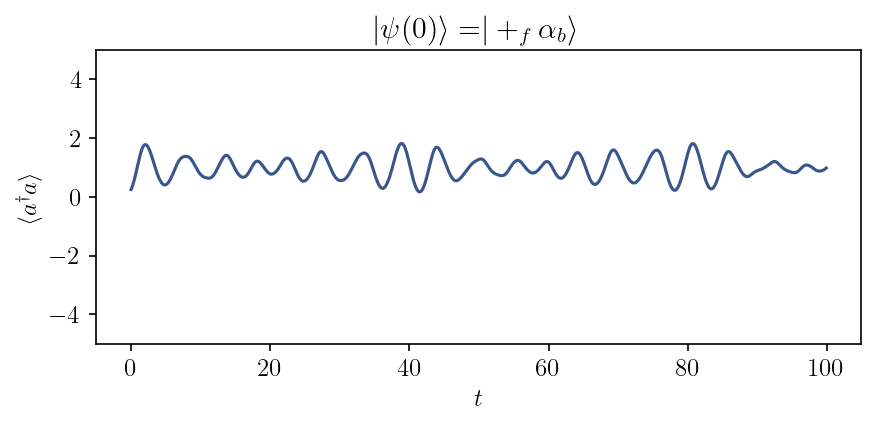

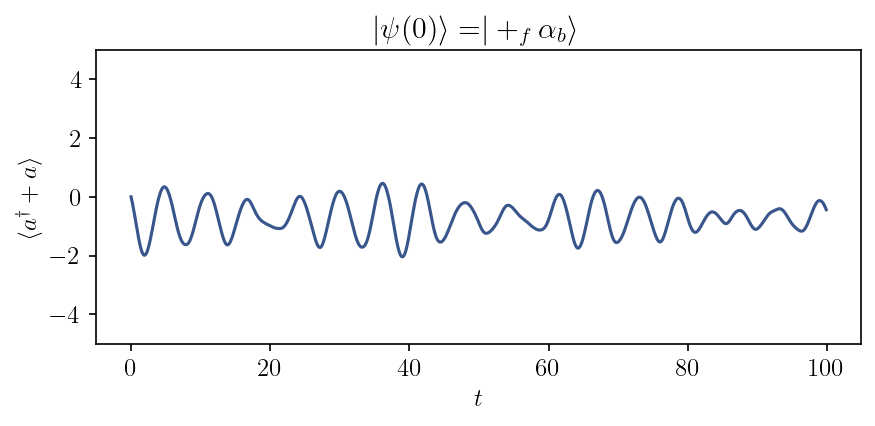

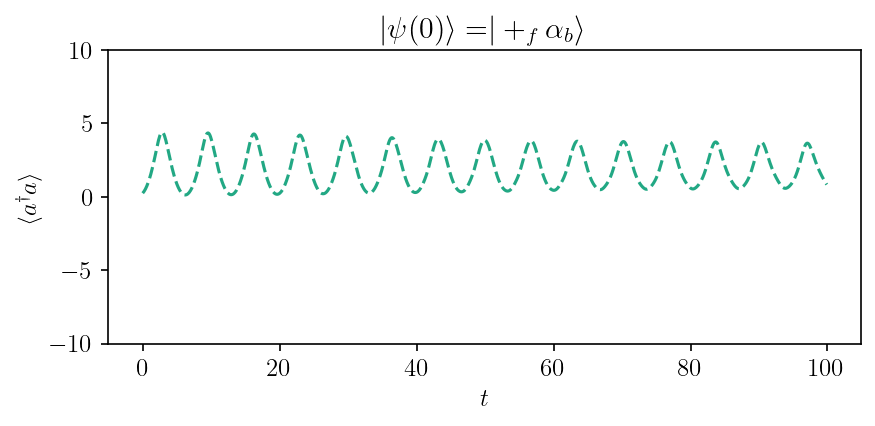

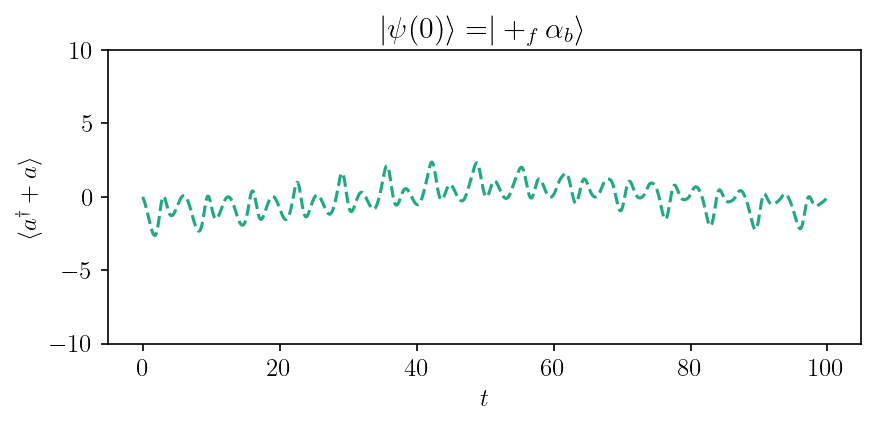

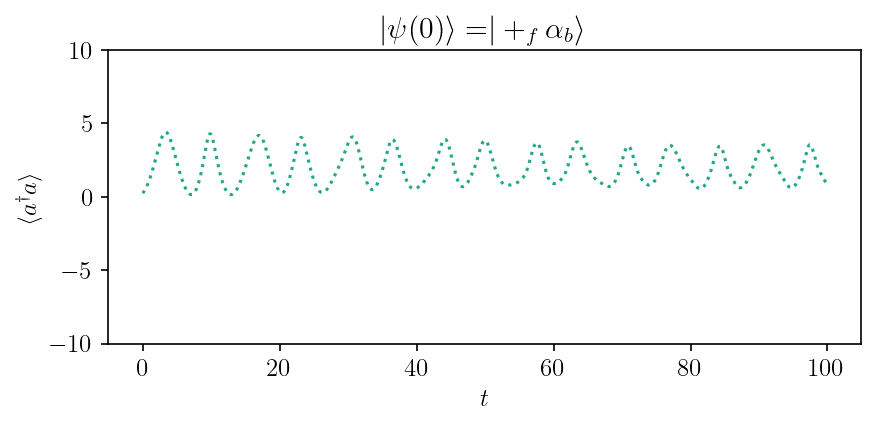

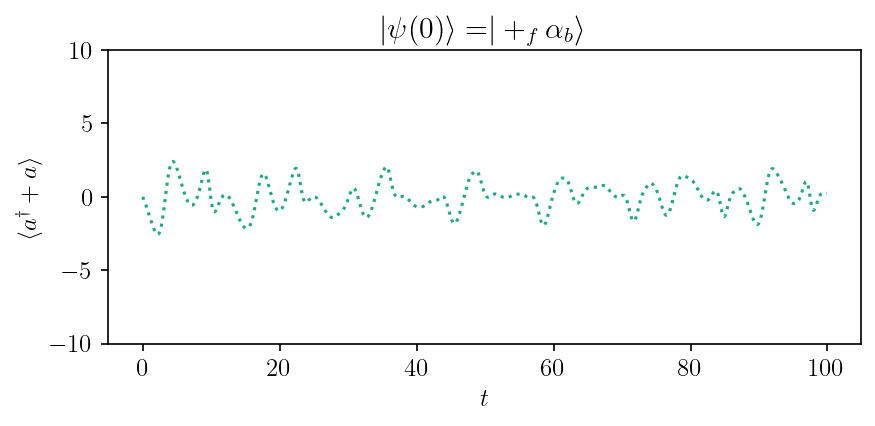

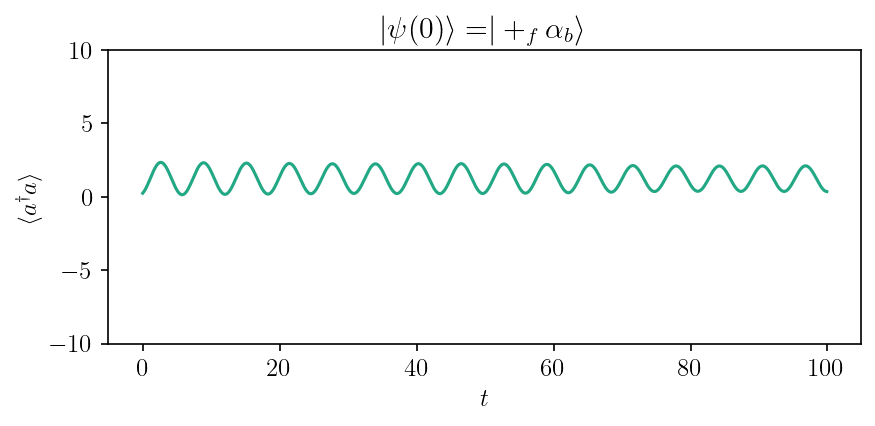

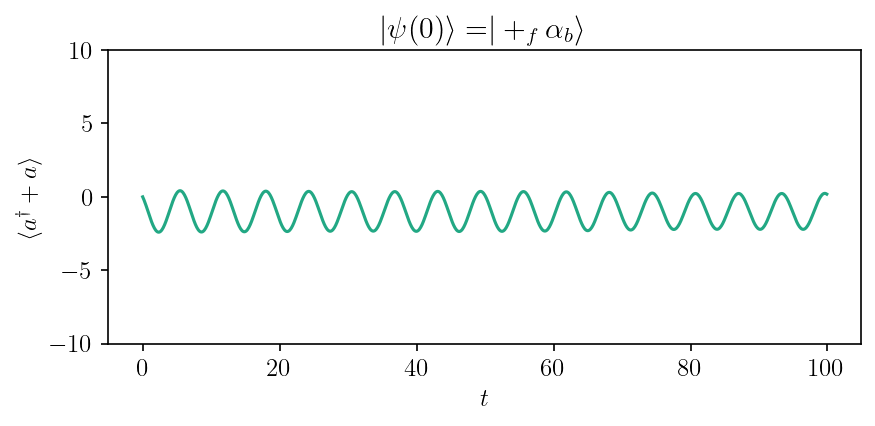

In [221]:
t_arr = np.arange(0, 100, 0.1)
Lambda_max = 2**4

for fermion_state in ['single_fermion', 'plus_fermion']:
    for boson_state in ['zero_boson', 'coherent_boson']:
        for Lambda in [3, 5, 10]:
            for trotterization_approximation in ['first_order', 'second_order', 'exact']:
                for operator_expectation in ['number_op_boson', 'position_op']:
                    exp_vals = compute_expectation_values_t(
                        fermion_state, boson_state, Lambda, trotterization_approximation, operator_expectation, t_arr
                    )
                    

                    if trotterization_approximation == 'exact':
                        linestyle = 'solid'
                    elif trotterization_approximation == 'first_order':
                        linestyle = 'dashed'
                    elif trotterization_approximation == 'second_order':
                        linestyle = 'dotted'

                    cmap = mpl.colormaps['viridis']
                    norm = mpl.colors.Normalize(vmin=1, vmax=Lambda_max)

                    plt.figure(figsize=(6, 3), dpi=150)
                    plt.plot(t_arr, exp_vals, linestyle = linestyle, color = cmap(norm(Lambda)))
                    plt.ylabel(
                        get_plot_y_label(operator_expectation)
                    )
                    plt.ylim(-Lambda, Lambda)
                    plt.title(get_plot_title(fermion_state, boson_state))
                    plt.xlabel(r'$t$')
                    plt.tight_layout()
                    plt.savefig(
                        './static_yukawa_plots/' + fermion_state + " " + boson_state + " " +
                        trotterization_approximation + " " + operator_expectation + " " +
                        'Lambda_' + str(Lambda) + '.pdf'
                                )
                    plt.show()

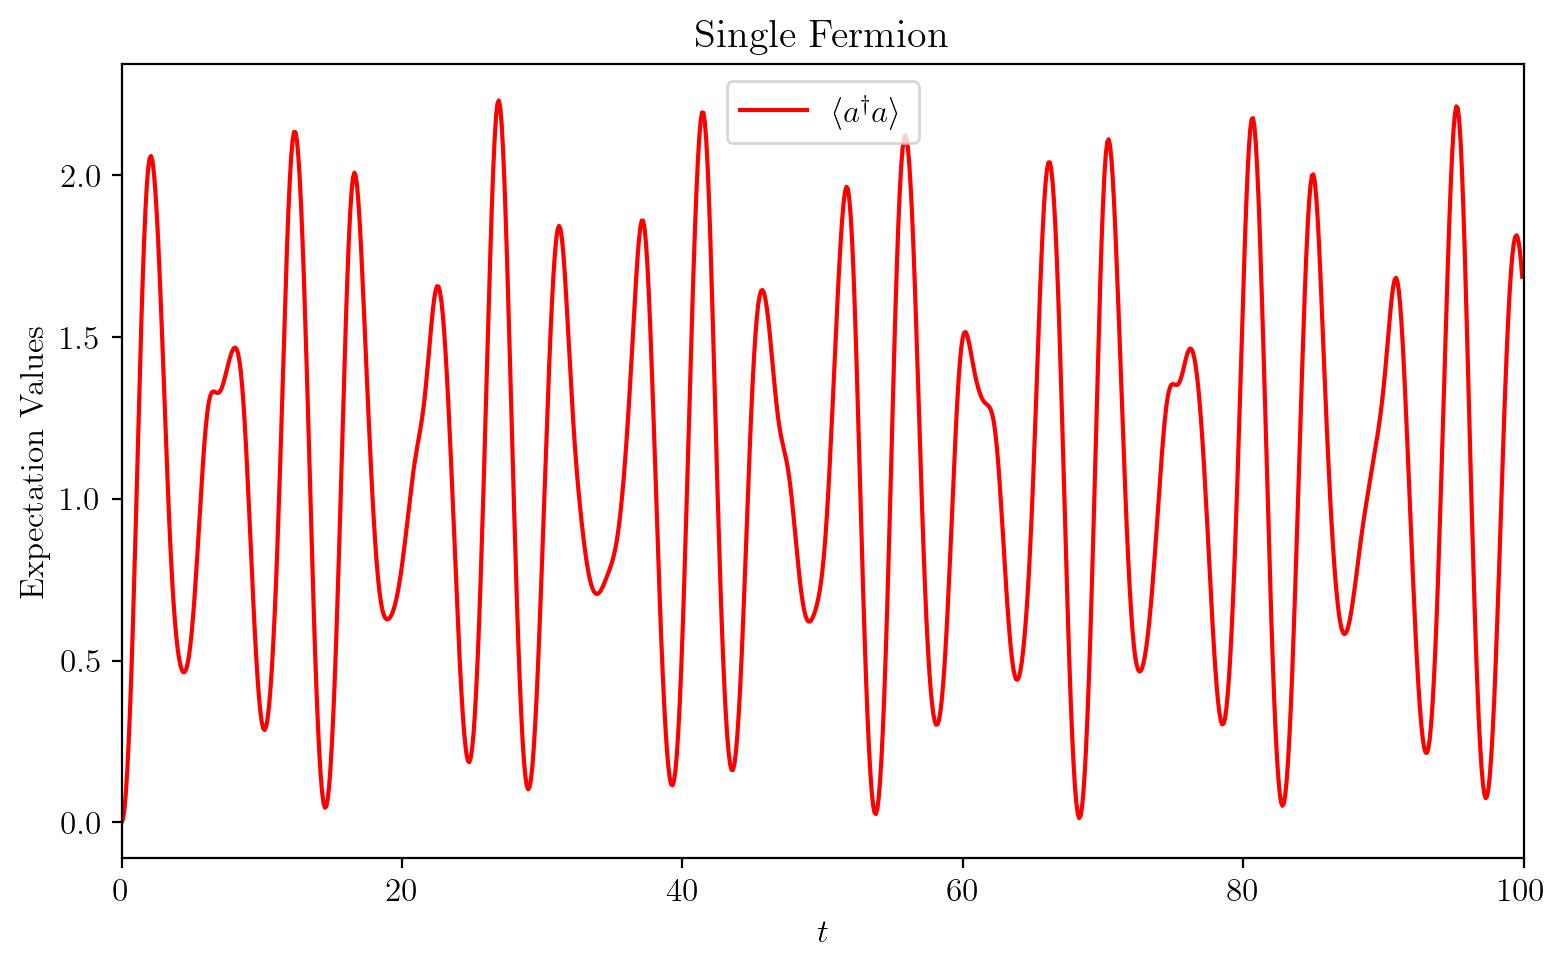

In [390]:
plt.figure(figsize=(8,5), dpi=200)

# plt.plot(t_arr, trotterized_expvals[0], color = 'k', linestyle = 'dashed')
# plt.plot(t_arr, trotterized_expvals[1], color = 'r', zorder = 1, linestyle = 'dashed')
# plt.plot(t_arr, trotterized_expvals[2], color = 'g', zorder = 2,  linestyle = 'dashed')

# plt.plot(t_arr, exact_expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$')
# plt.plot(t_arr, exact_expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$')
# plt.plot(t_arr, exact_expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$')


plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.legend()
plt.tight_layout()
# plt.savefig('./single_fermion.pdf')

(array([ 24,  26,  49,  51,  75, 925, 949, 951, 974, 976]), {})


(0.0, 0.1)

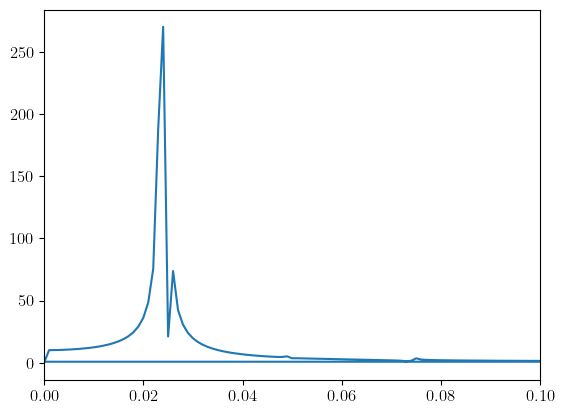

In [375]:
# freq_arr = np.fft.fftfreq(len(t_arr), d=t_arr[1] - t_arr[0])

N = len(t_arr)
freq_arr = np.fft.fftfreq(N)


fft_arr = scipy.fft.fft(np.array(expvals[1]).T[0] - np.average(expvals[1])).real

print(scipy.signal.find_peaks(np.abs(fft_arr)))
plt.plot(freq_arr, np.abs(fft_arr))
plt.xlim(0, 0.1)


In [376]:
fermion_state = np.array([[1, 0]]).reshape(-1, 1)
boson_state = np.zeros(Lambda + 1).reshape(-1, 1)
boson_state[0] = 1
boson_state = displacement_operator(alpha = -1j * g / 2, Lambda = Lambda) @ boson_state

statevector = np.kron(
    fermion_state,
    boson_state
)

t_arr = np.arange(0, 100, 0.1)
trotterized_expvals = compute_trotterized_expectations(statevector, t_arr, Ef, Eb, g, Lambda)
exact_expvals = compute_exact_expectations(statevector, t_arr, Ef, Eb, g, Lambda)

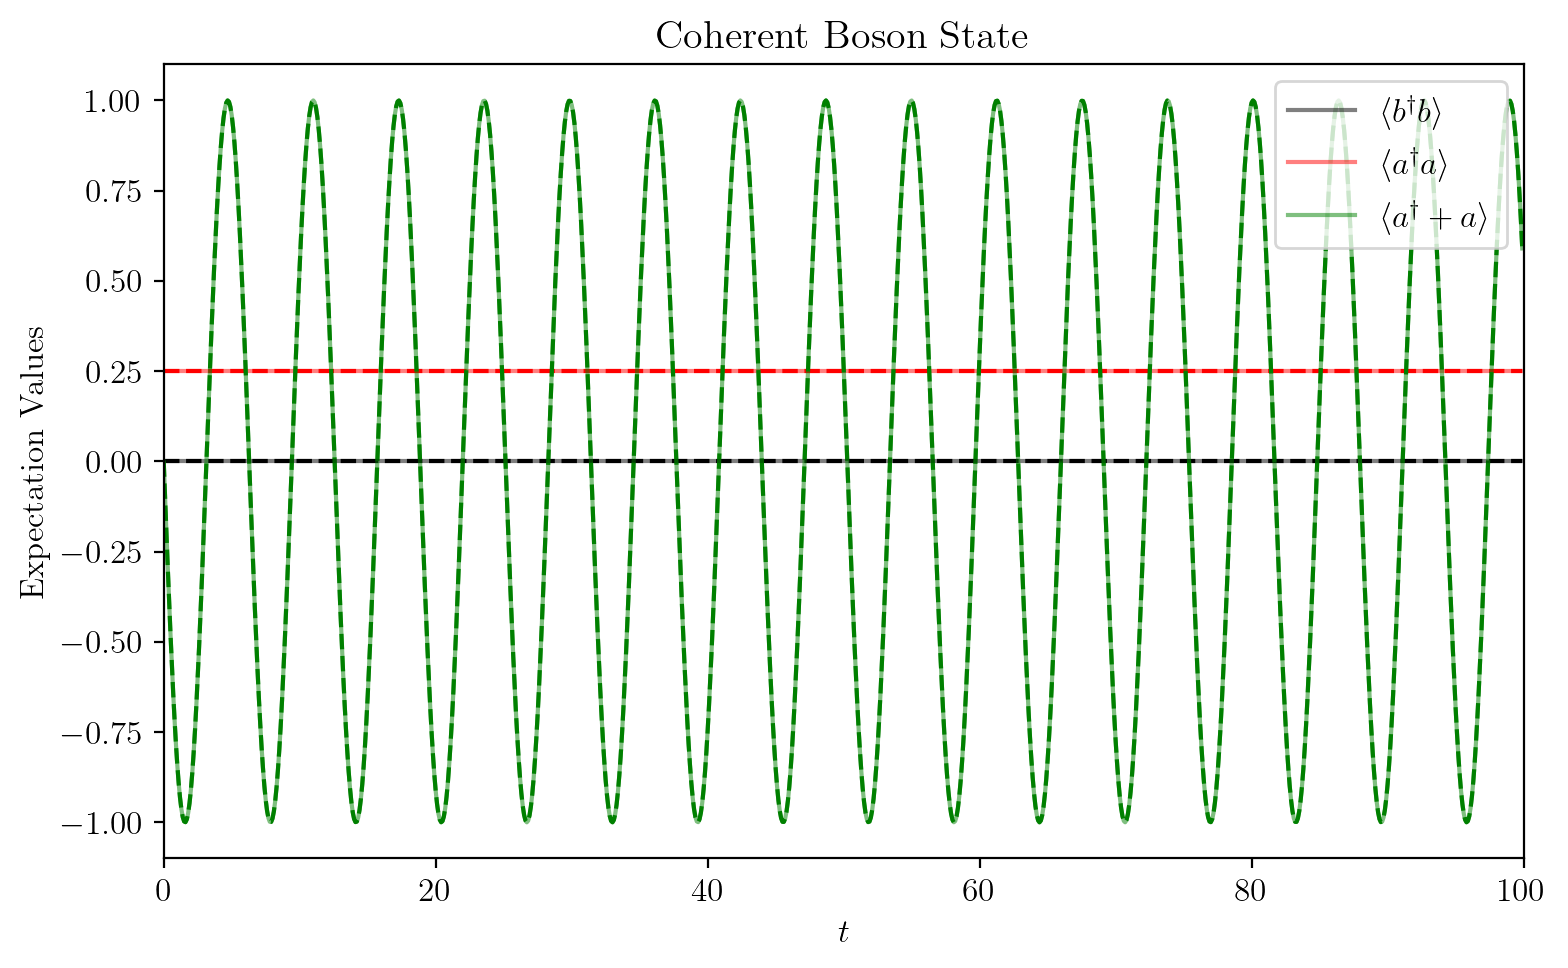

In [377]:
plt.figure(figsize=(8,5), dpi=200)

plt.plot(t_arr, trotterized_expvals[0], color = 'k', linestyle = 'dashed')
plt.plot(t_arr, trotterized_expvals[1], color = 'r', zorder = 1, linestyle = 'dashed')
plt.plot(t_arr, trotterized_expvals[2], color = 'g', zorder = 2,  linestyle = 'dashed')

plt.plot(t_arr, exact_expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$', alpha = 0.5)
plt.plot(t_arr, exact_expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$', alpha = 0.5)
plt.plot(t_arr, exact_expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$', alpha = 0.5)


plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.title("Coherent Boson State")
plt.legend()
plt.tight_layout()
# plt.savefig('./coherent_state.pdf')

In [378]:
fermion_state = np.array([[0, 1]]).reshape(-1, 1)
boson_state = np.zeros(Lambda + 1).reshape(-1, 1)
boson_state[0] = 1
boson_state = displacement_operator(alpha = -1j * g / 2, Lambda = Lambda) @ boson_state

statevector = np.kron(
    fermion_state,
    boson_state
)

t_arr = np.arange(0, 100, 0.1)
trotterized_expvals = compute_trotterized_expectations(statevector, t_arr, Ef, Eb, g, Lambda)
exact_expvals = compute_exact_expectations(statevector, t_arr, Ef, Eb, g, Lambda)

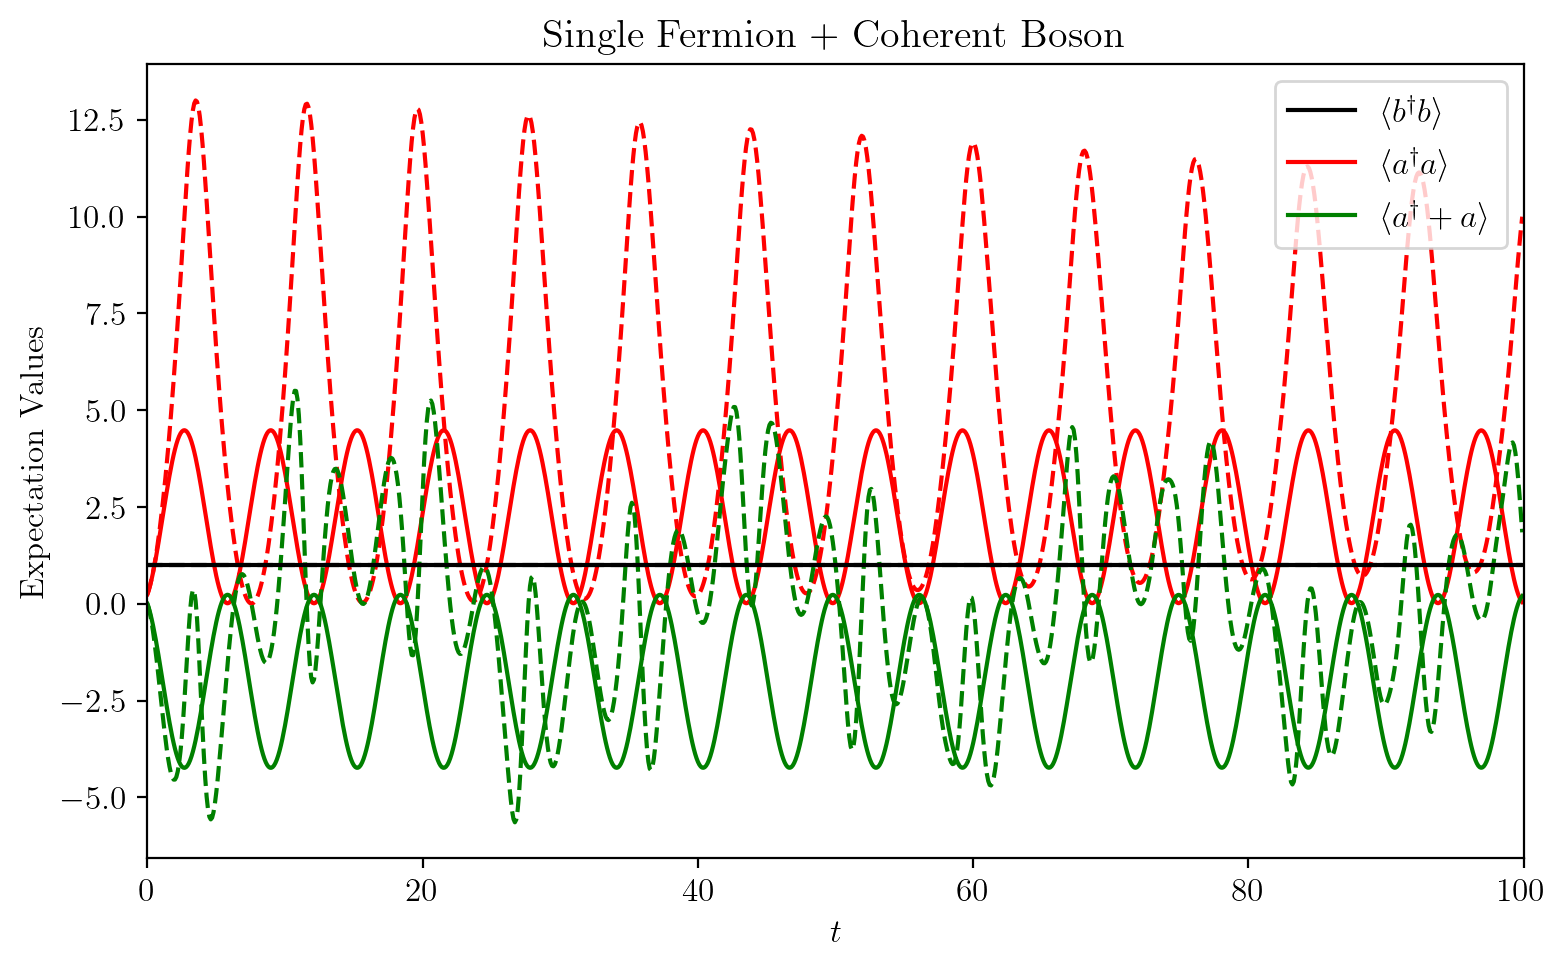

In [379]:
plt.figure(figsize=(8,5), dpi=200)


plt.plot(t_arr, trotterized_expvals[0], color = 'k', linestyle = 'dashed')
plt.plot(t_arr, trotterized_expvals[1], color = 'r', zorder = 1, linestyle = 'dashed')
plt.plot(t_arr, trotterized_expvals[2], color = 'g', zorder = 2,  linestyle = 'dashed')

plt.plot(t_arr, exact_expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$')
plt.plot(t_arr, exact_expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$')
plt.plot(t_arr, exact_expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$')

plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.title(r"Single Fermion $+$ Coherent Boson")
plt.legend()
plt.tight_layout()
# plt.savefig("./fermion_plus_coherent_state.pdf")